# Mega StratBuilder

This is the neatened StratBuilder code with some of my annoying essays. The main draw of this code is that it houses the components to interpret cross-stream and down stream sections, you just have to declare it. This code works by importing the full grids from NAYS2DH as a NumPy array and pulling out the model results for a specified location. It basically functions in 3 parts:
1. Data import
2. Plotting
3. Exports and some preliminary statistics

## Declare cross-stream or downstream flags

In [1]:
sec_flag = input('What kinds of sections are you plotting: XS or DWN: ')

What kinds of sections are you plotting: XS or DWN:  XS


## Import packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import csv
import os
import scipy.stats as stats
import seaborn as sns
import math 
import matplotlib.animation as animation
import matplotlib.colors as mcol
import matplotlib.cm as cm
import time
import random
import statistics as stat
import collections
import copy 

import matplotlib.gridspec as gridspec

from os import listdir
from os.path import isfile, join
import PIL
from scipy.interpolate import griddata

from xml.dom import minidom
from shapely.geometry import Polygon, MultiPolygon
#from matplotlib.animation import FuncAnimation

#from descartes import PolygonPatch
#from PIL import Image
from scipy.spatial import distance
from scipy import signal
from scipy import interpolate
from scipy.stats import variation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from celluloid import Camera
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

#plt.style.use('seaborn-white')

from matplotlib.collections import LineCollection, PatchCollection
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap

%matplotlib inline
#%matplotlib qt
#%matplotlib notebook
#from google.colab import drive
#drive.mount("/content/gdrive")

##### Setting up all the aesthetics:
Import new colormapas, reverse them, create plot style (font, font size, etc)

In [3]:
font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 8}

mpl.rc('font', **font)
kwargs = dict(edgecolor = 'k', fc = 'xkcd:greyish', alpha=0.5, bins=20)

In [4]:
 ###### source of this function: http://schubert.atmos.colostate.edu/~cslocum/custom_cmap.html#code
def make_cmap(colors, position=None, bit=False):

    if len(position) != len(colors):
        sys.exit('position length must be the same as colors')
    elif position[0] != 0 or position[-1] != 1:
        sys.exit('position must start with 0 and end with 1')
    
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):

        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

        cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)

    return cmap

##### load source xml file
xmldoc = minidom.parse('/Volumes/SAF_Data/Python/colourmaps/mellow-rainbow.xml')
itemlist = xmldoc.getElementsByTagName('Point')
data_vals=[]
color_vals=[]

for s in itemlist:
    
    data_vals.append(float(s.attributes['x'].value))
    color_vals.append((float(s.attributes['r'].value),
    float(s.attributes['g'].value),
    float(s.attributes['b'].value)))

##### construct the colormap

mycmap = make_cmap(color_vals,data_vals) ###this is the main rainbow colourmap to be used in the code
# print('converted successfully!')

#mycmap_r = ListedColormap(mycmap.colors[::-1])

# mycmap is matplotlib compatible object. to query color value out of it:

#print('example rgba value for data value 0 is: ' + str(mycmap(0.0)))

##### load source xml file
xmldoc = minidom.parse('/Volumes/SAF_Data/Python/colourmaps/brown-2.xml')
itemlist = xmldoc.getElementsByTagName('Point')
data_vals=[]
color_vals=[]

for s in itemlist:
    
    data_vals.append(float(s.attributes['x'].value))
    color_vals.append((float(s.attributes['r'].value),
    float(s.attributes['g'].value),
    float(s.attributes['b'].value)))

##### construct the colormap

ss_facies = make_cmap(color_vals,data_vals) ###this is the main rainbow colourmap to be used in the code
# print('converted successfully!')

##### load source xml file
xmldoc = minidom.parse('/Volumes/SAF_Data/Python/colourmaps//green-brown-div.xml')
itemlist = xmldoc.getElementsByTagName('Point')
data_vals=[]
color_vals=[]

for s in itemlist:
    
    data_vals.append(float(s.attributes['x'].value))
    color_vals.append((float(s.attributes['r'].value),
    float(s.attributes['g'].value),
    float(s.attributes['b'].value)))

##### construct the colormap

grads = make_cmap(color_vals,data_vals) ###this is the main rainbow colourmap to be used in the code
# print('converted successfully!')

xmldoc = minidom.parse('/Volumes/SAF_Data/Python/colourmaps/blue-3.xml')
itemlist = xmldoc.getElementsByTagName('Point')
data_vals=[]
color_vals=[]

for s in itemlist:
    
    data_vals.append(float(s.attributes['x'].value))
    color_vals.append((float(s.attributes['r'].value),
    float(s.attributes['g'].value),
    float(s.attributes['b'].value)))

##### construct the colormap

depths = make_cmap(color_vals,data_vals) ###this is the main rainbow colourmap to be used in the code
# print('converted successfully!')

###for velocities

xmldoc = minidom.parse('/Volumes/SAF_Data/Python/colourmaps/orange-6.xml')
itemlist = xmldoc.getElementsByTagName('Point')
data_vals=[]
color_vals=[]

for s in itemlist:
    
    data_vals.append(float(s.attributes['x'].value))
    color_vals.append((float(s.attributes['r'].value),
    float(s.attributes['g'].value),
    float(s.attributes['b'].value)))

##### construct the colormap

vels = make_cmap(color_vals,data_vals) ###this is the main rainbow colourmap to be used in the code
# print('converted successfully!')


# xmldoc = minidom.parse('/Volumes/SAF_Data/Python/colourmaps/1-3wbgy.xml')
# itemlist = xmldoc.getElementsByTagName('Point')
# data_vals=[]
# color_vals=[]

# for s in itemlist:
    
#     data_vals.append(float(s.attributes['x'].value))
#     color_vals.append((float(s.attributes['r'].value),
#     float(s.attributes['g'].value),
#     float(s.attributes['b'].value)))

# ##### construct the colormap

# planformcmap = make_cmap(color_vals,data_vals) ###this is the main rainbow colourmap to be used in the code
# print('converted successfully!')



In [5]:
def reverse_colourmap(cmap, name = 'my_cmap_r'):
    reverse = []
    k = []   

    for key in cmap._segmentdata:    
        k.append(key)
        channel = cmap._segmentdata[key]
        data = []

        for t in channel:                    
            data.append((1-t[0],t[2],t[1]))            
        reverse.append(sorted(data))    

    LinearL = dict(zip(k,reverse))
    my_cmap_r = mpl.colors.LinearSegmentedColormap(name, LinearL) 
    return my_cmap_r

In [6]:
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcol.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

In [7]:

# Links for colourmap help

# big up towards data science for the tutorial:
# https://towardsdatascience.com/creating-colormaps-in-matplotlib-4d4de78a04b8

# diy cmap from twoards data science, again: https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72


##### DEFINE COLOURMAPS
x, y = np.mgrid[-5:5:0.05, -5:5:0.05]
z = (np.sqrt(x**2 + y**2) + np.sin(x**2 + y**2))
hex_list = ['#0091ad', '#3fcdda', '#83f9f8', '#d6f6eb', '#fdf1d2', '#f8eaad', '#faaaae', '#ff57bb']
planform_colours = ['#3f9b0b', '#e2ca76', '#886806','02ccfe','#0485d1','#0504aa', ] 
                ###grass green, sand, shit, muddy brown, turquoise, cerulean, royal blue 

temperate= ['3f9b0b', 'bf9005', '02ccfe','3c9992', '0485d1', '0504aa' ] #ugly and green and glue
                    #dark tan, sand, sea green, cerulean, navy blue
test = ['a75e09','bd6c48', 'af884a', 'cb7723','7bc8f6','069af3', '0e87cc', '2242c77', '0504aa', '00035b'] 
#raw umber, adobe, dark tan, brownish orange, light blue, azure, water blue,  blue blue, royal blue, dark blue    
#test  = ['bd6c48','cb7723','ad8150', '0e87cc', '0504aa', '00035b']
#adobe, brownish orange, dark tan, light brown,water blue, royal blue, dark blue
glacial = ['ffffcb', 'e2ca76','bf9005', '7f5e00','6dedfd', '02ccfe','0504aa']
#dark sand, light grey, stone, azure, navy blue
redyellow = ['cf0234','e50000','ffffff', 'ffff14', 'fec615']
#cherry, red, white, yellow, golden yellow
redblue = ['cf0234','e50000', 'ffffff','152eff', '0203e2']
redblue_r = ['0203e2', '152eff','ffffff', 'e50000', 'cf0234']
yellowblue = ['fec615', 'ffff14', 'ffffff','152eff', '0203e2']
centrelines = ['ffffff', '000000']
discrete_channel = ['af884a', 'cb7723', '2242c77', '00035b']
#dark tan, brownish orange, water blue, dark blue
#cherry, red, white, vivid blue, pure blue

In [8]:
class MidpointNormalize(mcol.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        mcol.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [9]:
#planformcmap = reverse_colourmap(planformcmap)

In [10]:
ss_facies_r = reverse_colourmap(ss_facies)
timesteps_r = reverse_colourmap(mycmap)

### Important model parameters that might be used in calculation + import data:
At the moment (March 22) the only things we need to set are:
1. cross-section location (I and J)
1. DV flag (0 for none, 1 for variable)
1. adjustment time (60 for the 2 hour strat given an average adj time of 120 hours)

Need to expand and change cell width and length if not using a 4x10 cell size!

In [11]:
##### Q = str(100)# discharge in m3/s
slope = 0.00137#gradient
d50 = 0.31e-3 #d50 grain size in m

thot_SS = 0 # 802800
#time from which we restarted the runs to add a flood
fldstart_s = 802800 ###start time of flood in seconds
variabd = 0 #int(input('Enter DV flag: ')) #flag for if in variable discharge regime
adjustment_time = 65 #int(input('Enter bed adjustment time here, be wary of timestep conversion: ')) #number of timesteps, in hours taken for bed to equilibrate

fldlength = 0
idf = '0hfld' #identifier/classifier about the flood setting
intstring = '2hour' #time interval of output
nickname = 'agubh2-10km' #model nickname, agubh2, gentle_wide etc
floodname ='_0hrflood'

datnam = f'{idf}-datamaster-{intstring}-flux.npy' #name of the data file to upload
dataloc = f'data-{nickname}{floodname}' #where csv files are
arrayfolder = f'c-{idf}-{nickname}' #where raw centroid data array stored
mainsurfto = f'ms-{idf}-{nickname}' #where bounding surfaces array will go
iricoutputt =600 #output time from the model, s

print(f'/Volumes/SAF_Data/Data/ConvertedArrays/{dataloc}/{datnam}')
datamaster = np.load(f'/Volumes/SAF_Data/NAYS2DH_files/Data/ConvertedArrays/{dataloc}/{datnam}', allow_pickle = True)

iloc = int(input('I-location is '))#location of the section along i axis
jloc = 0 #int(input('j-location is '))#location of the secion along j axis

print('CHECK INPUTS!!!')

/Volumes/SAF_Data/Data/ConvertedArrays/data-agubh2-10km_0hrflood/0hfld-datamaster-2hour-flux.npy


I-location is  100


CHECK INPUTS!!!


### More model domain set up

In [12]:
cellW = 4
cellL = 10
xloc = iloc*cellL
xsloc = iloc*cellL
#print(xsloc)
spacing = 1 #spacing of cross stream x locations, m

ps = 2650 # bulk density of quartz kg/m3
p = 1000 # density of water in kg/m3
nu = 1.787*10e-6 #kinematic viscosity of water in m2/s
nu=1.0533e-6
g = 9.81 # acceleration due to gravity, m/s2

savefilesto = '/Volumes/SAF_Data/NAYS2DH_files/Plots/'
modelrun = f'{nickname}-{idf}-{iloc}'

In [13]:
###define grid dimensions
gridx = 1001
gridy = 26

datacond = 1
if datacond == 1:
    cells = gridy
else:
    cells = gridx
length = 1001 #length of the domain in the x direction
erostart = 5
erostop = 5

print('Shape of the datamaster dataset is: ', datamaster.shape)

Shape of the datamaster dataset is:  (26026, 12, 382)


In [14]:
num_timesteps = datamaster.shape[2] ##### or 168 for 2 weeks# len(os.listdir(filepathcore))-1 ###when u want to stop plotting
print('Number of timesteps being used: ', num_timesteps)
datamaster = datamaster[:, :, :num_timesteps]
position = np.arange(0, length, dtype = float)
coevelev = np.empty([num_timesteps])
interval_to_plot = 120/60 #we want to plot every ___  HOURS 
end_t = num_timesteps #len(np.arange(1, num_timesteps, skipstep)) #number of timesteps in data master array
fldstart = ((thot_SS+fldstart_s)/3600)/interval_to_plot ###flood starttime, s

print('Shape of data used to plot:', datamaster.shape)

Number of timesteps being used:  382
Shape of data used to plot: (26026, 12, 382)


#### Plotting full model domain


In [15]:
startpos = 100
endpos = 925
step = 25
ilocs = np.arange(startpos, endpos+1, step)
modelrun = f'{nickname}-{idf}-{iloc}'

### Now begin developing the sections 
### DO NOT TOUCH THIS CELL

for iloc in ilocs:
    if sec_flag == 'DWN': 
        upstream = int(input('Upstream limit of the reach: '))
        downstream = int(input('Downstream limit of the reach: '))
        modelrun = f'{nickname}-hr-{fldlength}hrfld-{upstream/10}-{downstream/10}'

        ### DEFINE REACH TO PLOT ###

        centreline = np.floor(np.average(abs(datamaster[:, 3, :]).min(axis = 0))) ##change this if you want a different section location
        print(centreline)

        fig, ax = plt.subplots(1, figsize = (10, 2), tight_layout = True, dpi = 200, sharex = True)
        #ax.set_xlim(upstream, downstream)
        ax.set_ylabel('Distance rel \n to centreline, m')
        ax.set_xlabel('Streamwise distance, m')

        ax.set_title(f'Final Topography, @ {end_t*interval_to_plot} hours')
        ylims = np.array([datamaster[:, 3, -1].min(),datamaster[:, 3, -1].max()])

        ax.axhline(centreline, c = 'r', ls = '--', lw = 1)
        ax.axvline(upstream, c = 'r', ls = '-', lw = 1)
        ax.axvline(downstream, c = 'r', ls = '-', lw = 1)
        dat_final = ax.pcolormesh(xdomain, ydomain, elev_final, cmap = get_continuous_cmap(test), norm = midnorm, shading = 'gouraud', alpha = 1)

        ax.fill_betweenx(ylims, [0, 0], [upstream, upstream], fc = 'w', alpha =.5)
        ax.fill_betweenx(ylims, [downstream, downstream], [datamaster[:, 2, -1].max(), datamaster[:, 2, -1].max()], fc = 'w', alpha =.5)

        fig.colorbar(dat_final, ax = ax, label = 'Flow Velocity, m', pad = 0.01, shrink = 0.5, aspect = 5)

        ax.set_aspect('equal')
        ax.xaxis.set_minor_locator(MultipleLocator(100))
        ax.grid(axis = 'x', which = 'both', alpha = 0.3)
        #plt.close(fig)

        ### NOW CROP THE DATA ###
        uend = upstream/10
        dend = downstream/10

        section_thresh = 1 #threshold distance around the transect to take data from

        remove_ilocs = np.where(np.logical_or(datamaster[:, 2, :]< upstream, datamaster[:, 2, :]> downstream))
        data = np.delete(datamaster, remove_ilocs[0], axis=0)


        ### 2D INTERPOLATIO OF GRIDS BEFORE EXTRAOLATING SECTION TRANSECT

        ## set the grid dimensions as the dimentions of the original rectangular grid so that we are sure to 
        ## extract full sections

        rbound = data[:, 3, 0].max() # right bound is positive, left negatice
        lbound = data[:, 3, 0].min()

        interplevel = 1 # we want to the spacing to be 0.5. This value is in metres
        grid_x, grid_y = np.mgrid[upstream:downstream:interplevel, lbound:rbound:interplevel] #create x and y grids

        ### NOW INTERPOLATE ALONG SECTION

        xy_topo = np.empty([grid_x.shape[0], grid_x.shape[1], end_t])
        sh = np.empty_like(xy_topo)
        fr = np.empty_like(xy_topo)
        dep = np.empty_like(xy_topo)
        vel = np.empty_like(xy_topo)

        for t in range (0, end_t):
            points = data[:, 2:4, t] #the points are the x and y locations in metres, so a 2D array of XY locs

            elevvals = data[:, 7, t] #the values are the variables you want, 7 for elevation change
            shearvals = data[:, 6, t] #the values are the variables you want
            depthvals = data[:, 4, t] #the values are the variables you want
            froudevals = data[:, 9, t] #the values are the variables you want
            velvals = data[:, 10, t] #the values are the variables you want


            xy_topo[:, :, t] = griddata(points, elevvals, (grid_x, grid_y), method='cubic') #the grid is the variables in their proper geographi poisiton 
            sh[:, :, t] = griddata(points, shearvals, (grid_x, grid_y), method='cubic') #the grid is the variables in their proper geographi poisiton 
            dep[:, :, t] = griddata(points, depthvals, (grid_x, grid_y), method='cubic') #the grid is the variables in their proper geographi poisiton 
            fr[:, :, t] = griddata(points, froudevals, (grid_x, grid_y), method='cubic') #the grid is the variables in their proper geographi poisiton 
            vel[:, :, t] = griddata(points, velvals, (grid_x, grid_y), method='cubic') #the grid is the variables in their proper geographi poisiton 

            if t==100:
                print("It is running gurl, b patient")
            if t==200:
                print('Getting there, almost done')
            if t==end_t-1:
                print('Okay, fin!!')

        rawstrat = copy.deepcopy(xy_topo)

        ## now we have to pull out the data arrays for the section only, in the traditional shape ([time, xlocation])

        xlocs = np.empty([grid_x.shape[0], end_t])
        xlocs = grid_x[np.where(grid_y==centreline)]
        xy_strat = xy_topo[np.where(grid_y==centreline)].T
        shear = sh[np.where(grid_y==centreline)].T
        froude = fr[np.where(grid_y==centreline)].T
        trueflow = dep[np.where(grid_y==centreline)].T
        #flowvel = vel[np.where(np.floor(grid_y)==centreline)].T ## just oin case the line doesnt work
        flowvel = vel[np.where(grid_y==centreline)].T
        xy_topo = copy.deepcopy(xy_strat)

    elif sec_flag == 'XS':


        ###Crop and sort the data by jloc (removing ilocs that are not the desired section) so its in section order and not streamwise

        #crop data
        remove_ilocs = np.where(datamaster[:, 0, :] != iloc)
        data = np.delete(datamaster, remove_ilocs[0], axis=0)
        print('Cropped, final dataset shape: ', data.shape)

        #sort in cross stream direction from rightbank to left bank
        #test = np.empty_like(datamaster)    
        for i in range (0, num_timesteps):
            data[:, :, i] = data[:, :, i][np.argsort(data[:, :, i][:, 3])]
            #print(i, data[:, 3, i])

        ### Now fill in arrays for elevation, position, shear etc...

        ###Make the arrays to store data
        stratigraphy = np.empty([end_t, cells]) ###will hold data for topography accounting for changes due to erosion
        #print(elevation.shape) #elevation = np.empty([n, end_t])

        # print('Shape of prelim arrays: ', stratigraphy.shape)

        #this matrix is to record unmodified stratigraphy in the same shape as the eroded strat
        stratigraphy_idx = stratigraphy.copy()
        #stratigraphy_idx[:] =  np.nan
        #print(stratigraphy)

        shearstresseroded = stratigraphy.copy() #will hold data for shear stress accounting for changes due to erosion
        #shearstresseroded[:] = np.nan
        #print('!!!', shearstresseroded.shape)

        stratflowdepth =  stratigraphy.copy() #will hold data for flow depth accounting for changes due to erosion
        #stratflowdepth[:] = np.nan

        scaleflowdepth =  stratigraphy.copy() #will hold data for local flow depth scaled to max accounting for changes due to erosion
        #scaleflowdepth[:] = np.nan

        froudedata =  stratigraphy.copy() #will hold data for local flow depth scaled to max accounting for changes due to erosion
        #froudedata[:] = np.nan

        velocity =  stratigraphy.copy()
        sflux =  stratigraphy.copy()
        runtime = len(stratigraphy)
        #print(runtime)
        xposition =  stratigraphy.copy()

        in_section = np.where(datamaster[:, 0, -1]==iloc)
        in_section = in_section[0]
        bankpos = datamaster[:, 3, :][in_section]
        #print(bankpos)
        rightbank = bankpos.min() ###negativee
        leftbank = bankpos.max() #positive
        print('Left bank max position: ', leftbank)
        print('Right bank max position: ', rightbank)

        xy_strat = np.empty([end_t, int(3+np.round((leftbank-rightbank)/spacing, 0))]) # will put stratigraphies here, in proper x pos
        print('Shape of stratigraphy matrix:, ', xy_strat.shape)
        xy_strat[:] = np.nan
        # ages = np.empty_like(xy_strat)

        # #### Import, and fill the arrays that will be used for the rest of the code
        # 1. Import data for shear stress, flow depth, velocity and froude
        # 2. Interpolate data to represent actual channel dimensions and not grid dimensions
        # 3. Fill and remove any remaining nans from the arrays

        ##### Import the data
        for time in range (0, data.shape[2]): #TIME
            #print(stratigraphy[time, :].shape)
            stratigraphy[time, :] = data[:, 7, time] #elevation change, elevation in 5
            shearstresseroded[time, :] = data[:, 6, time] 
            stratflowdepth[time, :] = data[:, 4, time]
            froudedata[time, :] = data[:, 9, time]
            velocity[time, :] = data[:, 10, time]
            sflux[time, :] = data[:, 11, time]

            ypos = data[:, 3, time]-rightbank #coreect supid centreline indexing
            #print(ypos)
            xposition[time, :] = ypos

        stratigraphy_idx = stratigraphy.copy()

        ###you need to change the y positions from centreline position to actual positional data
        #print(xposition.max(axis = 1))

        ##### these arrays will house interpolated data
        shear = xy_strat.copy()
        froude = xy_strat.copy()
        scaleflow = xy_strat.copy() #flow depth scaled to max per time
        trueflow = xy_strat.copy() #unscaled flow depth
        flowvel = xy_strat.copy() #flow velocity
        bedflux = xy_strat.copy() ## sed flux interpolated
        print('True shape, m: ', shear.shape, froude.shape, scaleflow.shape, trueflow.shape, flowvel.shape)

        #put all data values in their correct x/index position
        for t in range (0, end_t):
            #print(t)
            for idx, x in zip(np.arange(0, stratigraphy.shape[1]), xposition[t, :]):
                #print(x)
                #print(idx, x)
                x = int(np.floor(x)) #rounding down positions, making integers so can use as index
                #print(x, idx)
                xy_strat[t, x] = stratigraphy[t, idx]
                shear[t, x] = shearstresseroded[t, idx]
                froude[t, x] = froudedata[t, idx]
                trueflow[t, x] = stratflowdepth[t, idx]
                scaleflow[t, x] = scaleflowdepth[t, idx]
                flowvel[t, x] = velocity[t, idx]
                bedflux[t, x] = sflux[t, idx]
            #plt.plot(xy_strat[t, :], '.')

        xy_topo = np.empty_like(xy_strat)
        xy_topo[:] = np.nan
        for t in range (0, end_t):
            #print(t)
            length = int(np.floor(xposition[t, -1]-xposition[t, 0])) #length of the section at time, t
            pos = np.linspace(0, length, length) #create a metre scale array with each x pos = location
            #dataint = np.linspace(int(np.round(xposition[t, 0], 0)), int(np.round(xposition[t, -1], 0)), length, dtype=int) #range of locations to interpolate over?
            dataint = np.arange(xposition[t, 0], np.round(xposition[t, -1], 0), dtype=int)
            #print(t, pos.max(), length)
            #print(len(dataint))
            #print(pos)

            stratnotnan = xy_strat[t, :][~np.isnan(xy_strat[t, :])] #pull out real values of strat
            shearnotnan = shear[t, :][~np.isnan(shear[t, :])] #pull out real values of shear
            froudenotnan = froude[t, :][~np.isnan(froude[t, :])] #pull out real values of froude
            truefnotnan = trueflow[t, :][~np.isnan(trueflow[t, :])] #pull out real values of true flow depth
            #scalefnotnan = scaleflow[t, :][~np.isnan(scaleflow[t, :])] #pull out real values of scaled flow depth
            velnotnan = flowvel[t, :][~np.isnan(flowvel[t, :])] #pull out real values of strat
            fluxnotnan = bedflux[t, :][~np.isnan(bedflux[t, :])]
            #print(shear[t, :][~np.isnan(shear[t, :])])
            #print(shearnotnan[:].shape, froudenotnan[:].shape, truefnotnan[:].shape, velnotnan[:].shape)
            #print(xposition[t, :])
            #print(dataint)
            fx = interpolate.interp1d(xposition[t, :], stratnotnan[:], kind = 'cubic', fill_value = 'extrapolate') #stratigraphy interpolation
            #print(fx)
            fsh = interpolate.interp1d(xposition[t, :], shearnotnan[:], kind = 'cubic', fill_value = 'extrapolate') #shear stress interpolation
            ffr = interpolate.interp1d(xposition[t, :], froudenotnan[:], kind = 'cubic', fill_value = 'extrapolate') #froude number interpolation
            ftf = interpolate.interp1d(xposition[t, :], truefnotnan[:], kind = 'cubic', fill_value = 'extrapolate') #true flow depth interpolation
            #fsf = interpolate.interp1d(xposition[t, :], scalefnotnan[:], kind = 'cubic') #scaled flow depth interpolation
            ffv = interpolate.interp1d(xposition[t, :], velnotnan[:], kind = 'cubic', fill_value = 'extrapolate') #flow veloity interpolation
            fqb = interpolate.interp1d(xposition[t, :], fluxnotnan[:], kind = 'cubic', fill_value = 'extrapolate') #flow veloity interpolation
            #print(fx(dataint))

            xy_topo[t, dataint] = fx(dataint) #reassign strat
            #print(xy_topo[t, :])
            shear[t, dataint] = fsh(dataint) #reassign shear
            froude[t, dataint] = ffr(dataint) #reassign froude
            trueflow[t, dataint] = ftf(dataint) #reassign true fd
            #scaleflow[t, 0:length] = fsf(pos) #reassign scaled fd
            flowvel[t, dataint] = ffv(dataint) #reassign flow vel
            bedflux[t, dataint] = fqb(dataint)
            #plt.plot(xy_topo[t, :])
        #plt.ylim(-3, 3)

    start_time = 0 #would be start of model run
    end_time = end_t #would be end of model run

    tim = range(start_time,end_time) #range of time

    position = np.arange(0, xy_topo.shape[1], dtype = float)

    # Make a user-defined colormap.
    cm1 = mycmap
    cnorm = mcol.Normalize(vmin=min(tim),vmax=max(tim))

    # Turn these into an object that can be used to map time values to colors and can be passed to plt.colorbar().
    cpick = cm.ScalarMappable(norm=cnorm,cmap=timesteps_r) 
    cpick.set_array([])

    # ##### comparing van den berg and van gelder facies
    # mud brown = LSPB vv
    # dirt = ripples vv sb
    # sandy brown = dunes vv sb
    # tan = D-UPSB vv
    # beige = UPSB vv sb
    # stone = super high (antidunes, extra) vv sb

    cmap_vvfac = ListedColormap(['xkcd:mud brown', 'xkcd:shit', 'xkcd:dark tan', 'xkcd:sand', 'xkcd:stone'])
    mmprange = [0.01, 0.025, 0.17, 0.35, 1.5, 10] ##### LP, R, D, D-UP, UP
    norm_vvfac = BoundaryNorm(mmprange, cmap_vvfac.N)


    #each of these conditional arrays have a border of nans to helo pick out the 'packages'
    stratcondition = np.zeros_like(xy_topo)
    stratcondition[:] = np.nan
    ages = np.empty_like(xy_strat)


    erosurf = np.empty([end_t, xy_topo.shape[1]])
    erosurf[:] = np.nan


    #adjustment_time = 120
    #fig, ax = plt.subplots(time//adjustment_time, 2, tight_layout = True, figsize = (5, 4), dpi=200)
    #fig.subplots_adjust(wspace = 0.001)
    strat = copy.deepcopy(xy_topo)

    # turntime = int(input('What time interval do you want to see stratigraphy?'))

    # numfigs = len(np.where(np.logical_and(np.arange(0, end_t)%turntime==0, np.arange(0, end_t)>65)==True)[0])
    # fig, ax = plt.subplots(numfigs+1, 1, figsize = (numfigs*4, numfigs*1.5), dpi = 300, sharex = True, sharey = True, tight_layout = True)
    halfwidth=25
    axidx = 0
    for time in range (0, end_t):
        #plt.plot(stratigraphy[time]) #this is just a check to make sure youre importing the data correctly

        #now we have stratigraphy at each timestep with time on the j axis and position on the i
        #we want to check each location at each timestep for areas that have erodible elevation (i.e. higher than current timestep)

        for space in range (0, xy_topo.shape[1]):
            #print(space)
            preexisting_strata = xy_topo[:time, :] #this is our search array, where we will erode
            #preexisting_strata_idx = stratigraphy_idx[:time, :]

            #print(preexisting_strata.shape)
            #print('xy', xy_strat[time, :].shape)
            willerode = np.where(preexisting_strata[:, space] > xy_topo[time, space])
            #print('willerode', willerode)

            #print(time, column, willerode)

            xy_topo[willerode, space] = xy_topo[time, space]
            ages[willerode, space] = time        


    #     if time%turntime == 0 and time >= adjustment_time:
    #         plt.style.use('dark_background')
    #         for t in range(0, time):
    #             ax[axidx].plot(xy_topo[t, :], color=cpick.to_rgba(t), lw = 0.75, alpha = 0.5)

    #         ax[axidx].set_title(f'Stratigraphy if model were stopped at {time} timesteps', fontsize = 8)
    #         ax[axidx].set_aspect(10)
    #         # fig.colorbar(cpick, label="Time", ax=ax[axidx])

    #         axidx +=1

    #     if np.logical_and(time % adjustment_time == 0, time < end_t):
    #         axidx = int(time/adjustment_time)-1
    #         for adj in range (0, time):
    #             ax[axidx, 0].plot(xy_topo[adj, :], 'k', lw=0.1)
    #             ax[axidx, 0].set_title(time)
    #         ax[axidx, 0].set_xlim(xposition[-1, :].min(), xposition[-1, :].max())
    #         ax[axidx, 0].set_ylim(np.nanmin(xy_topo), np.nanmax(xy_topo))
    #         #ax[axidx, 0].set_aspect('15')
    #         ax[axidx, 1].pcolormesh(np.reshape(datamaster[:, 2, time], (gridy, gridx)), 
    #                                 np.reshape(datamaster[:, 3, time], (gridy, gridx)),
    #                                 np.reshape(datamaster[:, char, time], (gridy, gridx)),
    #                                 cmap = get_continuous_cmap(test), norm = midnorm, 
    #                                 shading = 'gouraud', alpha = 1)
    #         ax[axidx, 1].set_aspect('equal')
    #         ax[axidx, 1].axvline(xsloc, c='r',ls = '--')

    #         ax[axidx, 1].set_xlim((iloc-halfwidth)*cellL, (iloc+halfwidth)*cellL)
    #         ax[axidx, 1].set_ylim(ydomain.min(), ydomain.max())
            #stratigraphy_idx[willerode_idx, column] == np.nan
        #print(stratigraphy_idx[time])

    # for t in range (0, end_t):
    #     ax[-1].plot(xy_topo[t, :], color=cpick.to_rgba(t), lw = 1, alpha = 1)
    #     ax[-1].set_aspect(10)
    # plt.savefig(f'{savefilesto}timeseries/compositestrat-{modelrun}.png', dpi = 100, bbox_inches = 'tight', pad_inches = 0.1)
    #plt.ylim(0.1, 4)
        #print('st', stratigraphy)
    #print('sh', shearstresseroded)
    #print(ages[:5])
    ##### fill an areas with data 'above it' in the section

    if sec_flag == 'XS':
        for i in range (end_t-2, -1, -1):

            fillinx = np.where(np.isnan(xy_topo[i, :]))
            xy_topo[i, fillinx] = xy_topo[i+1, fillinx]
            #strat[i, fillinx] = strat[i+1, fillinx]
            ##### fill in all filled in areas in the strat condition matrix with the flag for erosion
            stratcondition[i, fillinx] = 1
            #print(stratcondition[i, fillinx])

            fillinsh = np.where(np.isnan(shear[i, :]))
            shear[i, fillinsh] = shear[i+1, fillinsh]

            fillinfr = np.where(np.isnan(froude[i, :]))
            froude[i, fillinfr] = froude[i+1, fillinfr]

            fillintf = np.where(np.isnan(trueflow[i, :]))
            trueflow[i, fillintf] = trueflow[i+1, fillintf]

            fillinsf = np.where(np.isnan(scaleflow[i, :]))
            scaleflow[i, fillinsf] = scaleflow[i+1, fillinsf]

            fillinfv = np.where(np.isnan(flowvel[i, :]))
            flowvel[i, fillinfv] = flowvel[i+1, fillinfv]

            fillinstrat = np.where(np.isnan(strat[i, :]))
            #strat[i, fillinstrat] = strat[i+1, fillinstrat]
            
            fillinqb = np.where(np.isnan(bedflux[i, :]))
            bedflux[i, fillinqb] = bedflux[i+1, fillinqb]

            #print('no fill', xy_topo[i, fillin])

            #print('fill', xy_topo[i, fillin])

    ## mobility parameter from van den berg and van gelder 1993
    temp = 20.0 #temperature in degrees celcius
    kv = (1.14-0.031*(temp-15)+0.00068*((temp-15)**2))*10**-6
    # print(kv)
    D_star = np.power((1.65*9.81)/(1e3*(kv**2)), 0.333)*3.1e-4
    # print(D_star)
    d50um = 310
    chezy_rough = 18*(np.log10(4*trueflow/d50)) #i think this is log10, else they would've put ln no?

    mmp =(p*(flowvel**2))/(1650*(chezy_rough**2)*d50)##### modified mobility parameter

    #remove excess duplcates from the mmp array
    for i in range (0, mmp.shape[0]-1):
                for j in range (0, mmp.shape[1]):
                    if np.logical_and(xy_topo[i, j] == xy_topo[i+1, j], mmp[i, j] <= mmp[i+1, j]):
                        mmp[i, j] = np.nan
                        shear[i, j] = np.nan
                        trueflow[i, j] = np.nan
                        flowvel[i, j] = np.nan
                        bedflux[i, j] = np.nan

    # np.save(f'/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/facies/{nickname}_{idf}_facies/fac{iloc}', mmp)
    
    master = np.dstack((xy_strat, xy_topo, shear, trueflow, flowvel, bedflux, mmp))
    np.save(f'/Volumes/SAF_Data/NAYS2DH_Files/Data/nparrays/streamwise-masters/{nickname}-{iloc}-master.npy', master)

Cropped, final dataset shape:  (26, 12, 382)
Left bank max position:  241.882453863
Right bank max position:  -230.065536143
Shape of stratigraphy matrix:,  (382, 475)
True shape, m:  (382, 475) (382, 475) (382, 475) (382, 475) (382, 475)


/var/folders/yg/89nlrh5x2xzgdlgr2bczm4_m0000gn/T/ipykernel_65129/2978420145.py:421: RuntimeWarning: invalid value encountered in log10
  chezy_rough = 18*(np.log10(4*trueflow/d50)) #i think this is log10, else they would've put ln no?


Cropped, final dataset shape:  (26, 12, 382)
Left bank max position:  195.357063292
Right bank max position:  -207.482449077
Shape of stratigraphy matrix:,  (382, 406)
True shape, m:  (382, 406) (382, 406) (382, 406) (382, 406) (382, 406)
Cropped, final dataset shape:  (26, 12, 382)
Left bank max position:  127.827579692
Right bank max position:  -151.687610767
Shape of stratigraphy matrix:,  (382, 283)
True shape, m:  (382, 283) (382, 283) (382, 283) (382, 283) (382, 283)
Cropped, final dataset shape:  (26, 12, 382)
Left bank max position:  186.254957275
Right bank max position:  -154.879859209
Shape of stratigraphy matrix:,  (382, 344)
True shape, m:  (382, 344) (382, 344) (382, 344) (382, 344) (382, 344)
Cropped, final dataset shape:  (26, 12, 382)
Left bank max position:  215.648601431
Right bank max position:  -157.216597514
Shape of stratigraphy matrix:,  (382, 376)
True shape, m:  (382, 376) (382, 376) (382, 376) (382, 376) (382, 376)
Cropped, final dataset shape:  (26, 12, 382)

*Verify that the stratigraphy looks the way it should*

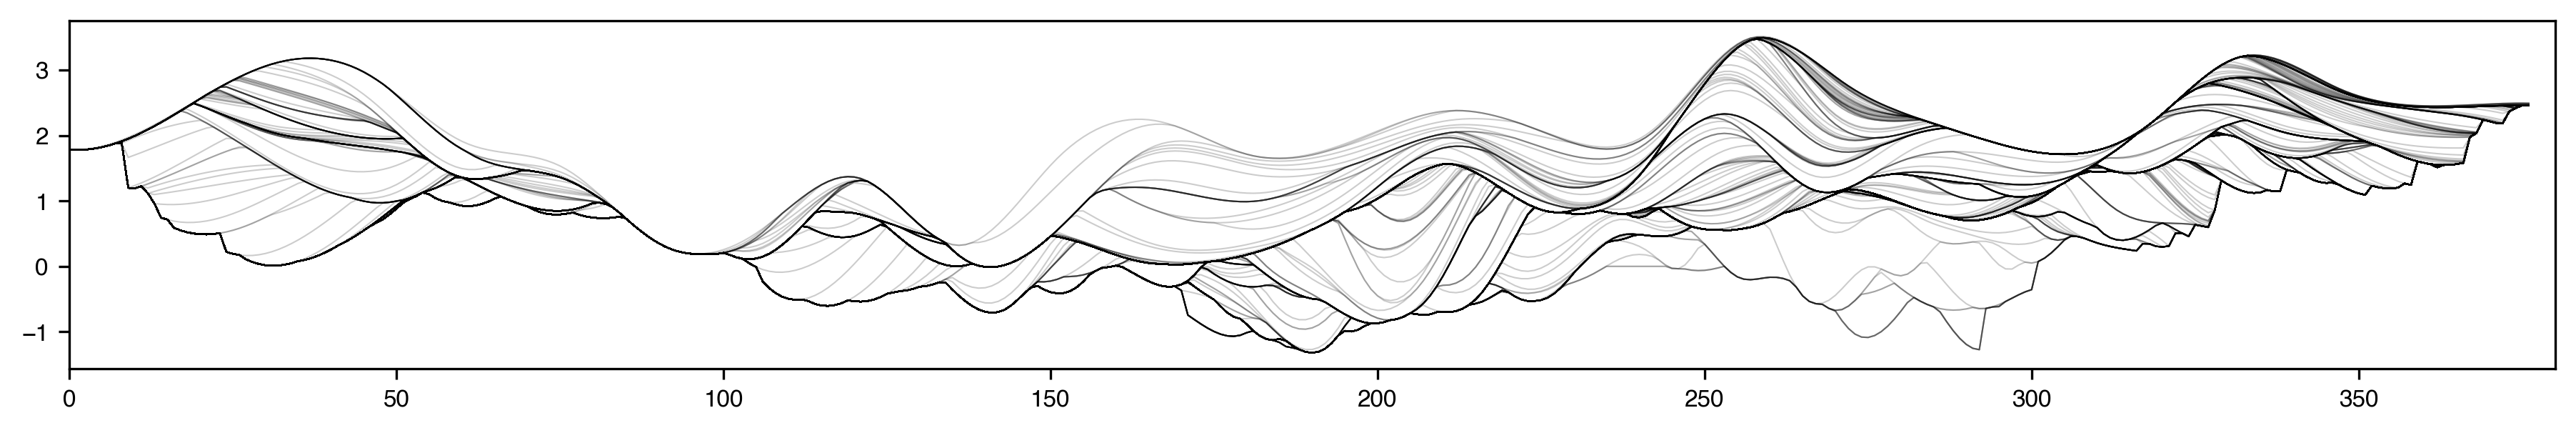

In [64]:
#%matplotlib notebook
fig, ax = plt.subplots(figsize = (12, 3), tight_layout=True, dpi=300)
for i in range(0, end_t):
    if sec_flag =='DWN':
        ax.plot(np.arange(upstream, downstream), xy_topo[i, :], 'k', alpha = 0.2, lw = 0.5)
        ax.set_xlim(upstream, downstream)
    else: 
        ax.plot(xy_topo[i, :], 'k', alpha = 0.2, lw = 0.5)
        ax.set_xlim(0, xy_topo.shape[1])
ax.set_aspect('10')

# ax.set_xlim(xposition[-1, :].min(), xposition[-1, :].max());
# ax.axvline(abs(data[:, 3, -1]).min()-rightbank, c='b', ls='-.', lw=1)
# plt.savefig(f'{savefilesto}showfig-{iloc}.png', dpi = 300)

In [113]:
maxflow = np.reshape(np.nanmax(trueflow, axis=1), [end_t, 1]) ## max flow across the section at each timestep
scaleflow = trueflow/maxflow

Maximum flow depth:  3.5292164429527686


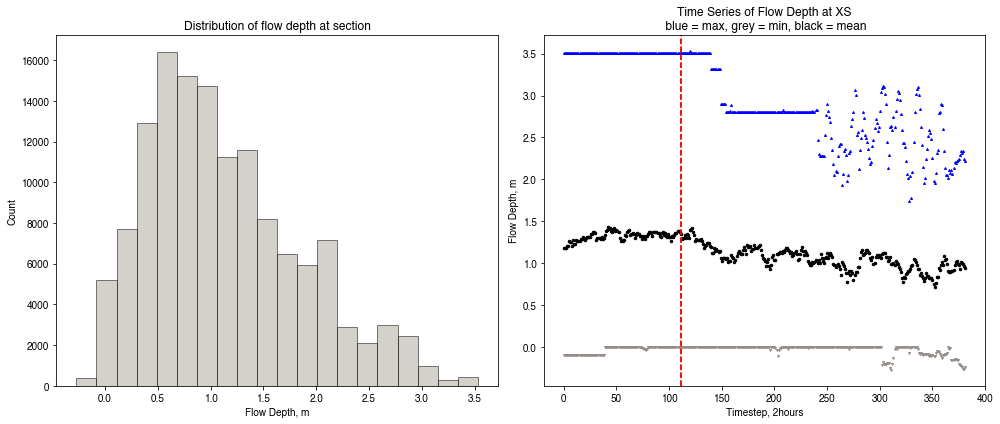

In [114]:
print('Maximum flow depth: ', maxflow.max())
fig, ax = plt.subplots(1, 2, figsize= (14, 6), tight_layout = True)
ax[0].hist(trueflow.ravel(), **kwargs)
flowdep = np.mean(trueflow)

for i in range (0, end_t):
    ax[1].plot(i, np.nanmin(trueflow[i, :]), marker = 'v', ms = '2', mec = 'xkcd:grey', mfc = 'r')
    ax[1].plot(i, np.nanmax(trueflow[i, :]), marker = '^', ms = '2', mec = 'b', mfc = 'b')
    ax[1].plot(i, np.nanmean(trueflow[i, :]), marker = '.', ms = '5', mec = 'k', mfc = 'k')
    
ax[1].set_title('Time Series of Flow Depth at XS\n blue = max, grey = min, black = mean') 
ax[0].set_title('Distribution of flow depth at section')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Flow Depth, m')

ax[1].set_ylabel('Flow Depth, m')
ax[1].set_xlabel('Timestep, 2hours')

ax[1].axvline(fldstart, c='r', ls = '--');
ax[1].axvline(fldstart+(fldlength/interval_to_plot), c='r', ls = '--');

# plt.close(fig)

#### Set up the grids for plotting and facies modelling

#### Create erosional, depositional and hiatal surfaces

In [118]:
ages_ero = np.zeros_like(xy_topo)
posnew = np.arange(0, xy_topo.shape[1])

In [119]:
##### SCENARIO 1: Hiatus = any elevation change that is less than x cm

##### SCENARIO 2: Hiatus = any elevation change that is less than x % of the average elevation change

##### SCENARIO 3: Hiatus = any elevation change that is less than the xth percentile of change at the timestep
hiatal_scenario = 2

threshold_thick = 0.005  #absolute value in metres 

nth = 25 #what percentile distribution to use to calculate hiatal surfaces for each timestep
perc = 0.1 #fraction of percentile

###### Now we are defining the ages of each surface 

In [120]:
#print(len(posnew))
for time in range (1, end_t):
    #print(time)
    ages_ero[time, :] = time 
    #stratinterpcub[time, :] = topointerp[time, :]
    
    lessthan = np.where(strat[time, :] < xy_topo[time-1, :]) ###where it erodes
    #print(lessthan)
    ele_change = strat[time, :]-xy_topo[time-1, :] #find the bed elevation change across the domain
                                                                   #it has to be before you reassign topography else 
                                                                   #you will get zeros where replaced
    #print(ele_change)
    #for space in range (0, ages_ero.shape[1]):
        
        #preexisting_strata_int = stratinterpcub[:time, :] #this is our search array, where we will erode
        
    #willerode_int = np.where(ele_change < 0)
    #print(willerode_int)
        #stratinterpcub[willerode_int, space] = stratinterpcub[time, space] #tune the stratigraphy for erosion
        
    ages_ero[time, lessthan] = ages_ero[time-1, lessthan]
        
    
    if hiatal_scenario == 1:
        threshold_thick = perc*(np.nanmean(ele_change)) #find the fraction of the average elevation change between the two latest timesteps
    
    if hiatal_scenario == 2:
        threshold_thick = perc*np.nanpercentile(ele_change, nth)
    
    if time != 0:
        hiatus_idx = np.where(abs(ele_change) < abs(threshold_thick))
       # print(time, hiatus_idx, threshold_thick)
    #print('change', ele_change)
    #print(time, hiatalrange, hiatus_idx)
    #print(time, np.mean(ele_change), hiatalrange)
        ages_ero[time, hiatus_idx] = ages_ero[time-1, hiatus_idx]
        #print(ages_ero[time, :])
ages_ero[-1, :] = end_t
#        print(ages_ero)

###### Now we construct the conditions of deposition, hiatus or erosion

This might be something to come back to becuase I currently do not have a working, transferrable definition of a hiatal surface, but for shits and giggles sake, since we are working with a field scale simulation and we expect m scale bars, lets say that a hiatal surface is a surface that aggrades less than 1mm ~ 0.1% of the elevation of the bar i.e. 0.99 x topo ≤ topo[t] ≤ 1.01 x topo[t-1]

Let's define erosion where topo[t] < 0.99 x topo[t]

Lets define deposition where topo[t] > 1.01 x topo[t-1]

Then we will make an array that houses the condition of the surfaces only (stratcondition) defined by whether the subsequent surface is eroding, depositing or non-depositing sediment 

#### Making the arrays that store erosion, hiatal, deposition and erosional and hiatal surfaces

In [121]:
#these will all be filled with nans
deposurf = erosurf.copy()
hiatalsurf = erosurf.copy()
erohiatalsurf = erosurf.copy()
time_of_ero = erosurf.copy()

###### Create stratcondition (0, 1, 2 for depo, ero, hiatal) and surface arrays with nans and topo of ero/depo/hiatal surfaces

In [122]:
#stratcondition = np.zeros_like(xy_topo)
#print(stratcondition.shape)

thickness = np.zeros_like(xy_topo)
#print(thickness.shape)

#erosurf[stratcondition==1] = xy_topo[stratcondition==1]

#hiatal_prop = 0.1 #multiple for proportion of thickness change defining a hiatal surface (decimal) 
                #i.e. a surface is hiatal if its elevation changes by less than 10% (of the percentile or average)

#stratcondition[0, :] = 0

fig, ax = plt.subplots(2, 3, figsize = (19.80, 10.8), tight_layout = True)#, sharey = True, sharex = True)#, sharex = True, sharey = True)

for time in range (1, end_t):
    
    
    #ax[0,0].plot(posnew, topointerp[time], color=cpick.to_rgba(time))
    thickness[time, :] = strat[time, :]-strat[time-1, :]
    thickness[time, :][np.isnan(thickness[time, :])] = 0
    #print(thickness[time, :])
    ax[0,1].plot(time, thickness[time, :].max(), marker = 'o', mew = 0, markerfacecolor = 'xkcd:cobalt blue')
    ax[0,1].plot(time, thickness[time, :].min(), marker = 'o', mew = 0, markerfacecolor = 'xkcd:green yellow')
    ax[0,1].plot(time, np.average(thickness[time, :]), marker = 'o', mew = 0, markerfacecolor = 'xkcd:coral')
    #print(thickness[time, :].max(), thickness[time, :].min(), np.average(thickness[time, :]))
    #print(thickness[thickness>0])
    #ax[0, 1].set_xlim(0, end_t)
    #ax[0, 1].set_ylim(-1, 1)
    if hiatal_scenario == 1:
            #using a percentage of the average thickness to constrain hiatal surfaces
        threshold_thick = perc*(np.mean(thickness[time, :]))  #x% of the average sediment thickness at x time. may be negative.
    elif hiatal_scenario == 2:
            #using nth percentile of the thicknesses at each timestep
        threshold_thick = perc*np.percentile(abs(thickness[time, :]), nth) #find the nth percentile of depositon at x time. positive number.
    
    ax[0,0].plot(time, threshold_thick, 'o', markerfacecolor = cpick.to_rgba(time), markeredgecolor = cpick.to_rgba(time), linewidth = 0.0001, markersize = 14, alpha = 0.5)
    
    
    ax[0,0].set_ylim(-0.05, .05)
    #print('10th', np.percentile(abs(thickness), nth), 'thresh', threshold_thick)
    
    hiatalwhere = np.where(abs(thickness[time, :]) < threshold_thick) #where elev change is less than 10% avg
    depositingwhere = np.where(thickness[time, :] > threshold_thick)
    erodingwhere = np.where(thickness[time, :] < -abs(threshold_thick))
    #print(time, depositing where)
    
    
    #print(time, 'hiatus', hiatalwhere)
    #print('hdata', thickness[hiatalwhere])
    #print(time, 'ero', erodingwhere)
    #print('edata', thickness[thickness<0])
    
    #print(time, stratcondition[time, :])
    
    stratcondition[time, depositingwhere] = 0
    stratcondition[time, erodingwhere] = 1
    stratcondition[time, hiatalwhere] = 2
    erodereset = np.where(stratcondition[time, :]==1)
   
    #print(erodingwhere, erodereset)
    #print(stratcondition[time, :])
    #print(erodereset)
    #erosurf[time, erodingwhere] = xy_topo[time, erodingwhere]
    erosurf[time, erodereset] = xy_topo[time, erodereset]
    deposurf[time, depositingwhere] = xy_topo[time, depositingwhere]
    hiatalsurf[time, hiatalwhere] = xy_topo[time, hiatalwhere]
    erohiatalsurf[time, erodereset] = xy_topo[time, erodereset]
    erohiatalsurf[time, hiatalwhere] = xy_topo[time, hiatalwhere]
    #print('surf', erosurf[time, 220:])
    
    ax[1,0].plot(erosurf[time], color=cpick.to_rgba(time))
    ax[1,1].plot(hiatalsurf[time], color=cpick.to_rgba(time))
    ax[0, 2].plot(deposurf[time], color=cpick.to_rgba(time))
    #ax[1, 2].plot(posnew, erohiatalsurf[time], color=cpick.to_rgba(time))
    ax[1, 2].plot(erosurf[time], 'r')
    ax[1, 2].plot(hiatalsurf[time], 'g')
#erohiatalsurf[-1, :] = xy_topo[-1, :]

#ax[1, 3].hist(percentile)
#ax[0, 3].hist(abs(thickness).flatten())
#ax[0, 3].axvline(x=np.percentile(abs(thickness), 1), c = 'r')   
ax[0,0].title.set_text('Time Series of Threshold thickness vals')
ax[0,1].title.set_text('time seties of bed elevation changes')
ax[0,2].title.set_text('Depositional Surfaces Only')
ax[1,0].title.set_text('Erosion Surfaces Only')
ax[1,1].title.set_text('Hiatal Surfaces Only')
ax[1,2].title.set_text('Erosional and Hiatal Surfaces')
#ax[0, 3].title.set_text('Distribution of ALL thicknesses, red line = '+str(nth)+'th Percentile')
#ax[1, 3].title.set_text('Distribution of ALL percentiles/timestep')

ax[0, 1].legend()
ax[0,0].set_facecolor('xkcd:grey') 
ax[0,1].set_facecolor('xkcd:grey') 
ax[0,2].set_facecolor('xkcd:grey') 
ax[1,0].set_facecolor('xkcd:grey') 
ax[1,1].set_facecolor('xkcd:grey') 
ax[1,2].set_facecolor('xkcd:grey') 
#print(thickness[3, :])
#print(stratcondition)#[3, :])
#np.where(stratcondition == 1)

#plt.savefig(savefilesto+'surf_creation/'+modelrun+'testforhiat.png', format='png', dpi = 200)
plt.close(fig)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


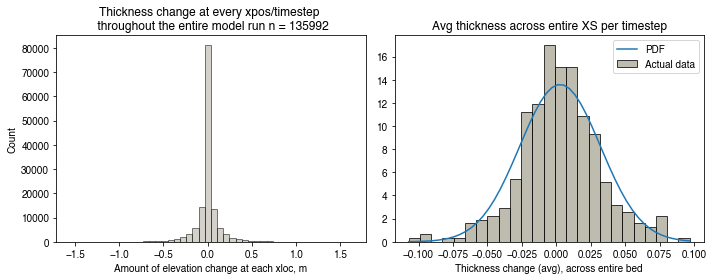

In [123]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4), tight_layout = True)
hist = ax[0].hist(thickness.ravel(), bins = 50, ec = 'k', fc = 'xkcd:greyish', alpha = 0.5)
ax[0].set_xlim(thickness.min(), thickness.max())
thickavg = np.average(thickness, axis = 1)
loc = np.average(thickavg)
scale = np.std(thickavg)
x = np.linspace(thickavg.min(), thickavg.max())
y = stats.norm.pdf(x, loc, scale)

ax[1].plot(x, y, label = 'PDF')
ax[0].set_xlabel('Amount of elevation change at each xloc, m')
ax[0].set_ylabel('Count')
ax[0].set_title('Thickness change at every xpos/timestep \n throughout the entire model run n = '+str(len(thickness.ravel())))
#ax[0].set_xlim(-0.1, 0.1)

avghist = ax[1].hist(thickavg, bins = 25, ec = 'k', fc = 'xkcd:greyish', alpha = 0.75, density = True, label = 'Actual data')
ax[1].set_title('Avg thickness across entire XS per timestep')
ax[1].set_xlabel('Thickness change (avg), across entire bed')
ax[1].legend()
#plt.savefig(savefilesto+'stats/'+modelrun+'erodephist.png', dpi = 100)


##### Plot Stratigraphy with erosurfaces and hiatals colourised

*Save data as arrays to compare CDFs*

np.save(f'/Volumes/SAF_MSCWORK/Python/Stratigraphy/Data/nparrays/velocity/{nickname}_{idf}_vel/v{iloc}', flowvel)
np.save(f'/Volumes/SAF_MSCWORK/Python/Stratigraphy/Data/nparrays/depth/{nickname}_{idf}_depth/v{iloc}', trueflow)
np.save(f'/Volumes/SAF_MSCWORK/Python/Stratigraphy/Data/nparrays/facies/{nickname}_{idf}_tparam/fac{iloc}', Tparam)
np.save(f'/Volumes/SAF_MSCWORK/Python/Stratigraphy/Data/nparrays/shearstress/{nickname}_{idf}_ss/ss{iloc}', shear)
np.save(f'/Volumes/SAF_MSCWORK/Python/Stratigraphy/Data/nparrays/discharge/{nickname}_{idf}_q/cq{iloc}', cellularQ)
np.save(f'/Volumes/SAF_MSCWORK/Python/Stratigraphy/Data/nparrays/xytopo/{nickname}_{idf}_topo/topo{iloc}', xy_topo)

nbins = 1+3.122*math.log(len(xy_topo), 10)
nbins = np.round(nbins, 0)
print(nbins)

tpoh, tpob = np.histogram(xy_topo.ravel(), range = (np.nanmin(xy_topo), np.nanmax(xy_topo)), bins=int(nbins))
sheh, sheb = np.histogram(shear.ravel(), range = (np.nanmin(shear), np.nanmax(shear)), bins=int(nbins))
deph, depb = np.histogram(trueflow.ravel(), range = (np.nanmin(trueflow), np.nanmax(trueflow)), bins=int(nbins))
velh, velb = np.histogram(flowvel.ravel(), range = (np.nanmin(flowvel), np.nanmax(flowvel)), bins=int(nbins))

variablist = [tpoh, tpob, sheh, sheb, deph, depb, velh, velb]
masterh = np.dstack((tpoh, sheh, deph, velh))
masterb = np.dstack((tpob, sheb, depb, velb))
np.save(f'/Volumes/SAF_MSCWORK/Python/Stratigraphy/Data/nparrays/masterhist/{nickname}_{idf}-h/h_{nickname}_{iloc}', masterh)
np.save(f'/Volumes/SAF_MSCWORK/Python/Stratigraphy/Data/nparrays/masterbins/{nickname}_{idf}-b/b_{nickname}_{iloc}', masterb)

##### create plot of the timestep the surface was last touched

sums = np.zeros_like(xy_topo)
#sums = np.delete(sums, 0, axis=0)
for cols in range (0, sums.shape[1]):
    uniques = np.unique(ages_ero[1:, cols]) ###find the unique ages in the ages matrix
    for ul, uu  in zip(uniques[:-1], uniques[1:]):
        clip = int((uu-ul))
        #print(clip, uu, ul)
        change = np.where(ages_ero[:, cols]==ul)[0].astype(int)
        st = change[0]
        sums[st:st+clip, cols] = np.arange(0, clip)
                

#np.arange(0, clip)
sums[st:st+clip, cols]

fig, ax = plt.subplots(2, sharex = True, sharey = True, squeeze = True, tight_layout = True, figsize = (10, 5))

for t in range (0, end_t):
    elev = xy_topo[t]
    depage = ages_ero[t]
    hiatal_time = sums[t]
    
    pointsint = np.array([posnew, elev]).T.reshape(-1, 1, 2)
    segmentsint = np.concatenate([pointsint[:-1], pointsint[1:]], axis=1)
    
    depnorm = plt.Normalize(0, end_t)
    hiatal_norm = plt.Normalize(0, 5)
    
    depL = LineCollection(segmentsint, cmap = 'hsv', norm = depnorm)
    depL.set_array(depage)
    depL.set_linewidth(1.5)
    depL_line = ax[0].add_collection(depL)

    hiatal_lc = LineCollection(segmentsint, cmap = 'hsv', norm = hiatal_norm)
    hiatal_lc.set_array(hiatal_time)
    hiatal_lc.set_linewidth(1.5)
    hiatal_lc_line = ax[1].add_collection(hiatal_lc)
    
ax[0].set_facecolor('xkcd:midnight blue')
ax[1].set_facecolor('xkcd:midnight blue')

ax[0].set_ylim(np.nanmin(xy_topo), np.nanmax(xy_topo))
ax[0].set_xlim(0, posnew.max())
ax[0].set_title('just the age at the location')

depcb = fig.colorbar(depL_line, label = 'Surface Age', ax=ax[0], pad = 0.01, shrink=0.7)
hiatcb = fig.colorbar(hiatal_lc_line, label = "growth pkg", ax=ax[1],pad = 0.01, shrink=0.7)

### MAKE PLOTS

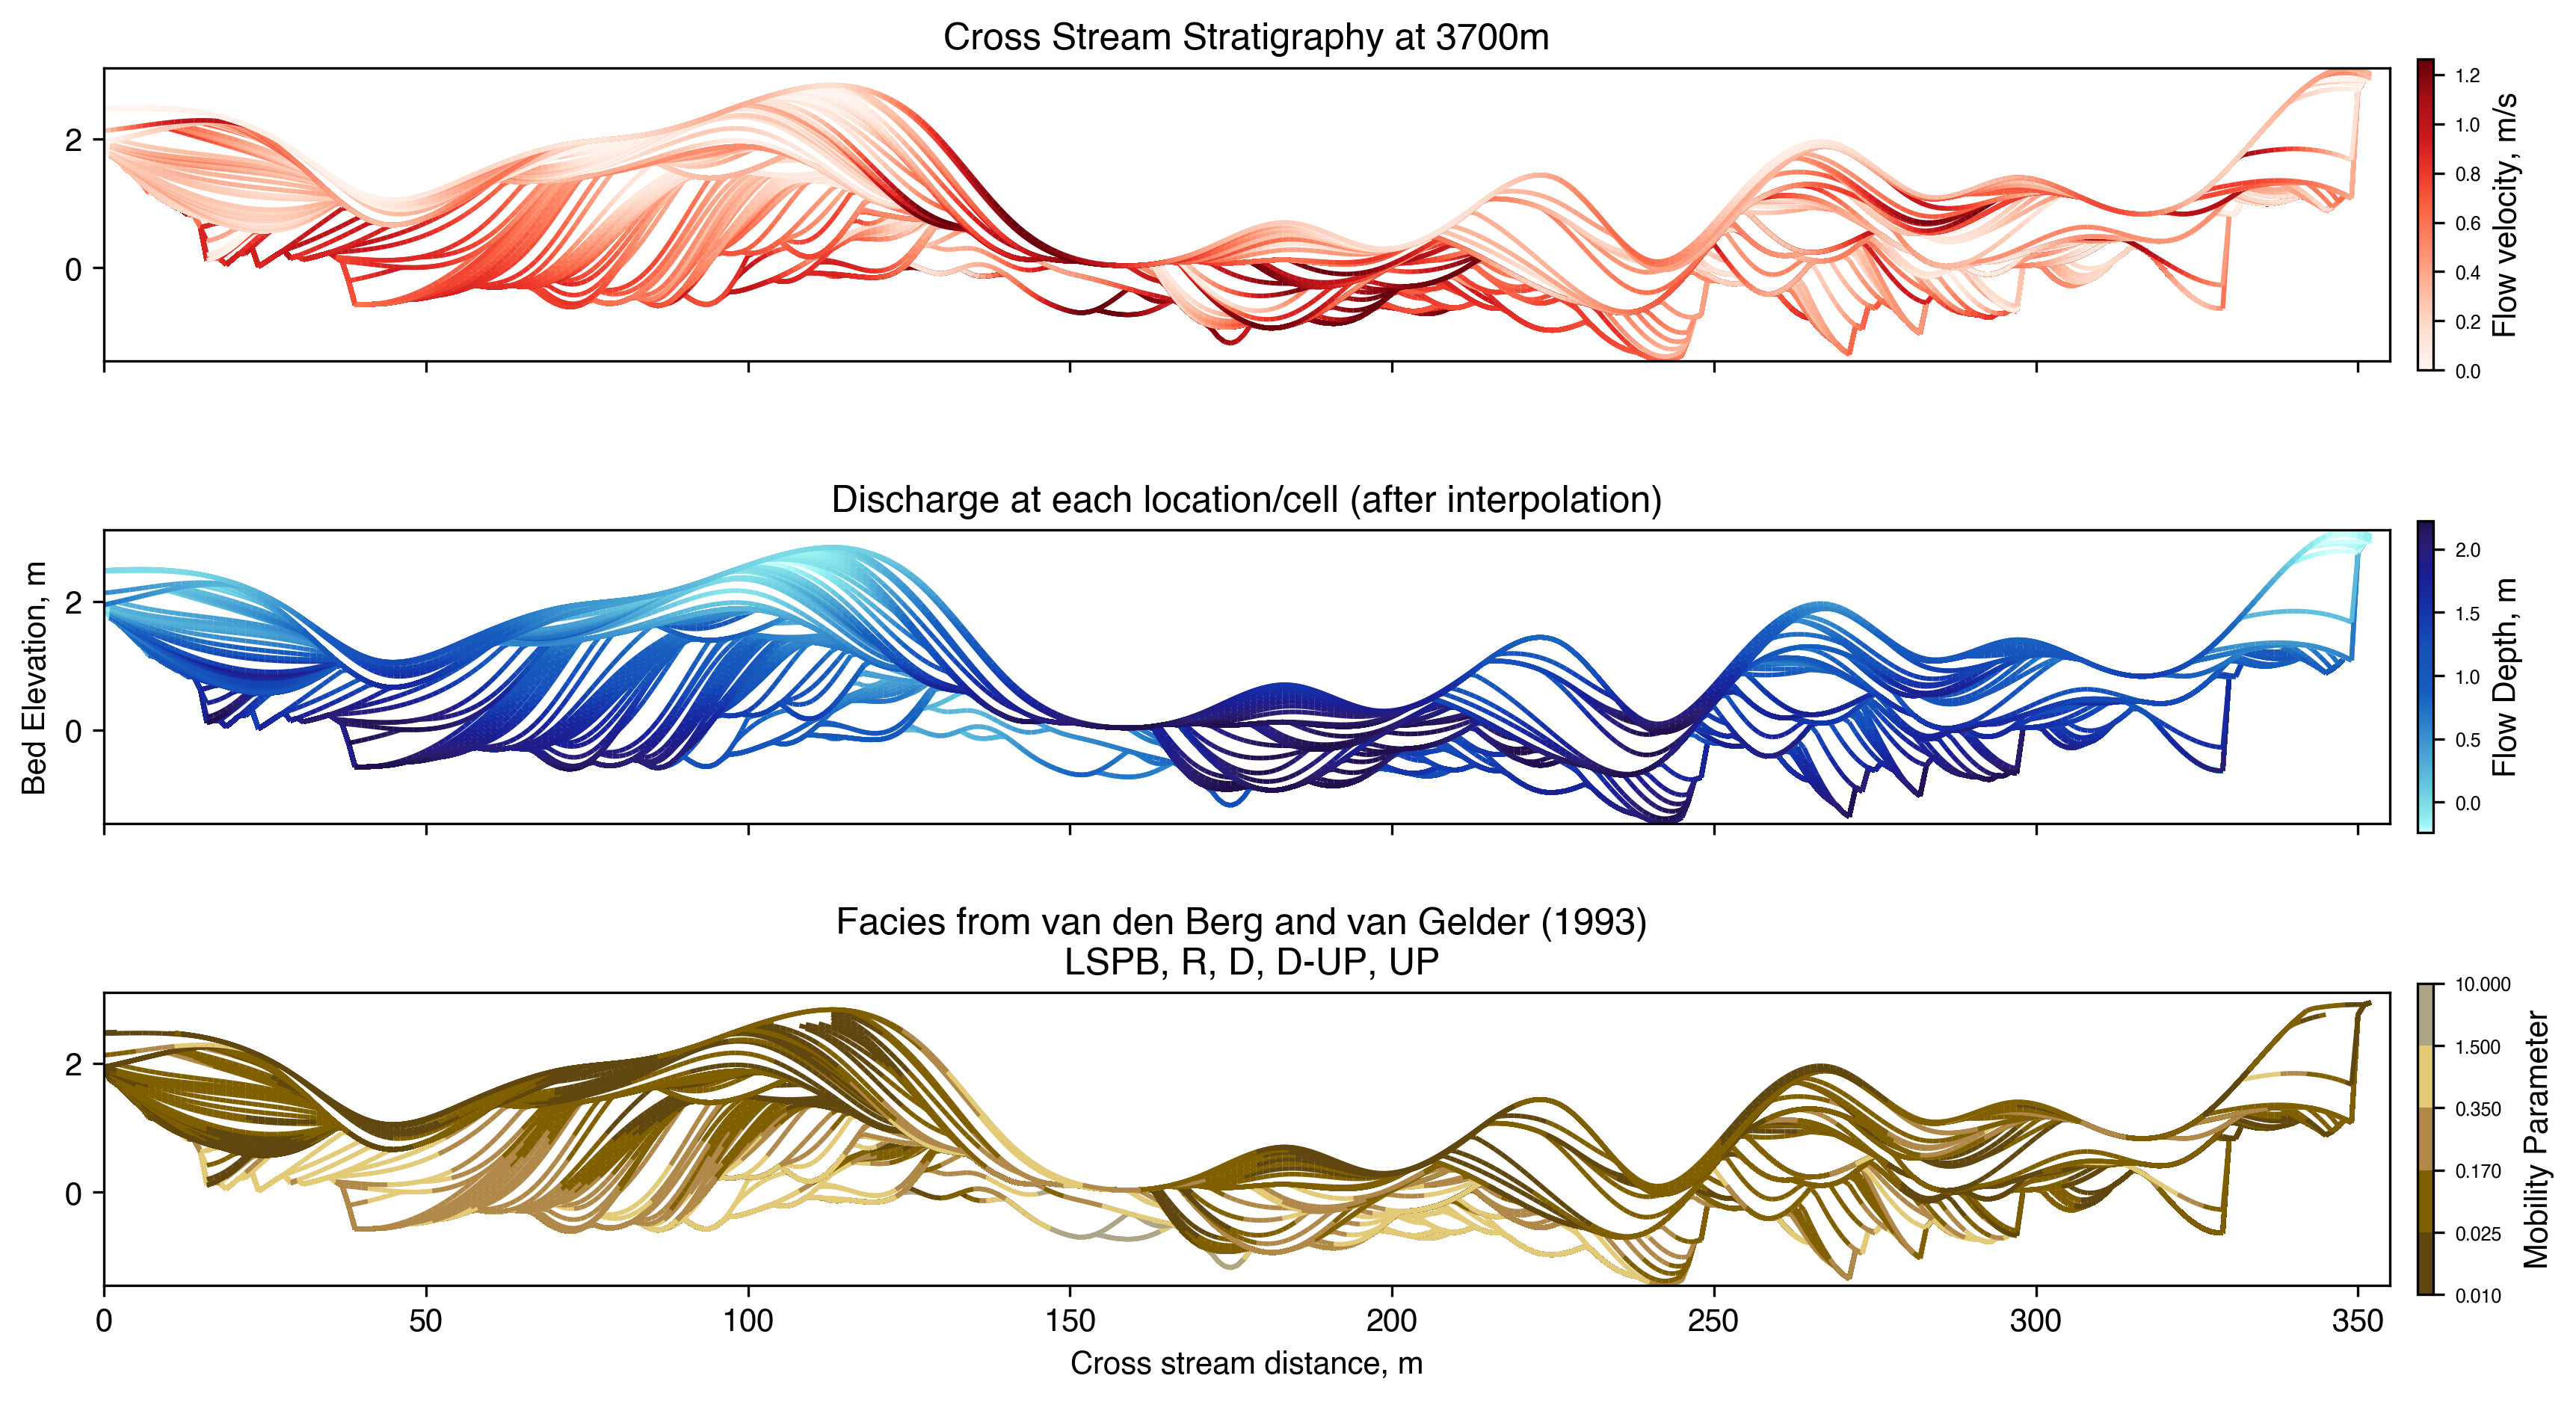

In [124]:
start_time = 0 #would be start of model run
end_time_int = num_timesteps-1 #would be end of model run

tim_int = range(start_time,end_time) #range of time
xdat_int = posnew #position
ydat_int = [xy_topo[t] for t in tim_int] #stratigraphy/elevation @ position

#with plt.style.context('dark_background'):
fig, (ax1, ax2, ax4) = plt.subplots(3, 1, sharex=True, sharey=True, squeeze = True, tight_layout=True, figsize=(38.40/3,  21.60/3), dpi = 300)
fig.subplots_adjust(hspace=.05)

#for y, t in zip(ydat_int,tim_int):
#    stratig = ax1.plot(xdat_int,y,color=cpick.to_rgba(t), lw = 3, alpha = 1)

#fig.colorbar(cpick,label="Time", ax=ax1)

for strata in range (0, end_t):

    ax1.set_xlim((posnew.min(), posnew.max())) #braided test
    #ax1.set_xlim((4000, 5000))
    #ax1.set_ylim((-2.5, 2.5))
    ax1.set_ylim(np.nanmin(xy_topo), np.nanmax(xy_topo)) #braided test

    ################## PULL THE DATA OUT FOR EACH TIMESTEP

    elevint = xy_topo[strata]
    shearstressint = shear[strata]
    depthint = scaleflow[strata]
    actualdepth = trueflow[strata]*flowvel[strata] #we do not want scaled flow depth for the facies
    cellularQ = trueflow[strata]#*flowvel[strata] 
    #froudenumint = froudecub[strata]
    #slopeint = gradcub[strata]
    #froudenum[0] = is.nan
    velint = flowvel[strata]
    #transportstage = Tparam[strata]
    vvfacies = mmp[strata] #van den berg and van gelder

    pointsint = np.array([posnew, elevint]).T.reshape(-1, 1, 2)
    segmentsint = np.concatenate([pointsint[:-1], pointsint[1:]], axis=1)

    ################## SET UP THE NORMALISATION

    sheargradint = plt.Normalize(np.nanmin(shear), np.nanmax(shear)) #bed shear based on skin friction for anti dunes = 4.410)
    cellQint = plt.Normalize(np.nanmin(cellularQ), np.nanmax(cellularQ))
    depth_quant = plt.Normalize(np.nanmin(depthint), np.nanquantile(trueflow, 0.95))
    velogradint = plt.Normalize(np.nanmin(velint), np.nanmax(velint)) ###gradient plot for flow velocity
    acdepth = plt.Normalize(np.nanmin(actualdepth), np.nanmax(actualdepth)) #normalistion with the aactual flow depth
    shear_quant = plt.Normalize(np.nanmin(shear), np.nanquantile(shear, 0.99)) #normalising ot shear stress max 99th ptile bc 10 is too high
    #transport = plt.Normalize(np.nanmin(transportstage), np.nanmax(transportstage)) ###gradient plot for flow velocity



  ################## MAKE THE LINE COLLECTIONS ################

    #-------- SHEAR STRESS
#     gradlcint = LineCollection(segmentsint, cmap=plt.get_cmap(ss_facies_r), norm=shear_quant)
#     #gradlcint = LineCollection(segmentsint, cmap=cmap, norm=normbd)

#     gradlcint.set_array(shearstressint)
#     gradlcint.set_linewidth(1.5)
#     gradlineint = ax3.add_collection(gradlcint)

#     #-------- SCALED FLOW DEPTH
    #depthlcint = LineCollection(segmentsint, cmap=plt.get_cmap(depths), norm=depth_quant)
    #depthlcint.set_array(actualdepth)
    #depthlcint.set_linewidth(3)

    #depthlineint = ax2.add_collection(depthlcint)

    ######----Not actually cellular discharge, this is flow depth
    cellularQint = LineCollection(segmentsint, cmap=plt.get_cmap(depths), norm=cellQint)
    cellularQint.set_array(cellularQ)
    cellularQint.set_linewidth(1.5)

    cellularQline = ax2.add_collection(cellularQint)

    #-------- DOUBLE PLOT OF VELOCITY/FLOW DEPTH AND SHEAR STRESS
#    vel_mix = LineCollection(segmentsint, cmap=get_continuous_cmap(redyellow), norm=velogradint)
    vel_mix = LineCollection(segmentsint, cmap='Reds', norm=velogradint)
    vel_mix.set_array(velint)
    vel_mix.set_linewidth(1.5)

#    shear_mix = LineCollection(segmentsint, cmap=get_continuous_cmap(yellowblue), norm=shear_quant)
#     shear_mix = LineCollection(segmentsint, cmap='Blues', norm=shear_quant)
#     shear_mix.set_array(shearstressint)
#     shear_mix.set_alpha(0.7)

#     depth_mix = LineCollection(segmentsint, cmap=get_continuous_cmap(redyellow), norm=depth_quant)
#     depth_mix.set_array(depthint)
#     depth_mix.set_alpha(0.5)

#    shear_mix_line = ax1.add_collection(shear_mix)
    #depth_mix_line = ax1.add_collection(depth_mix)
    vel_mix_line = ax1.add_collection(vel_mix)
    #-------- FROUDE NUMBER
    #froudegradint = plt.Normalize(froudenumint.min(), froudenumint.max())

    #froudelcint = LineCollection(segmentsint, cmap=plt.get_cmap('seismic'), norm=froudegradint)
    #froudelcint.set_array(froudenumint)
    #froudelcint.set_linewidth(2.5)

    #froudelineint = ax4.add_collection(froudelcint)

    #-------- VELOCITY    

    #velolcint = LineCollection(segmentsint, cmap = cmap_fac, norm = normbd)
    #velolcint.set_array(velint)
    #velolcint.set_linewidth(3)

    #-------- MOBILITY PARAMETER (FACIES)

    #transportlc = LineCollection(segmentsint, cmap = cmap_fac, norm = norm_fac)
    #transportlc.set_array(transportstage)
    #transportlc.set_linewidth(2)
    #transportline = ax4.add_collection(transportlc)

    #-------- MOBILITY WITH MMP
    vvfac = LineCollection(segmentsint, cmap = cmap_vvfac, norm = norm_vvfac)
    vvfac.set_array(vvfacies)
    vvfac.set_linewidth(1.5)
    vvfac_line = ax4.add_collection(vvfac)


if variabd == 1:
    ax1.plot(xy_topo[pref_idx], 'r--', lw = 3)
    ax2.plot(xy_topo[pref_idx], 'r--', lw = 3)
#   ax3.plot(xy_topo[pref_idx], 'r--', lw = 3)
    ax4.plot(xy_topo[pref_idx], 'r--', lw = 3)


# ax1.set_facecolor('xkcd:midnight blue')
# ax2.set_facecolor('xkcd:midnight blue')
# #ax3.set_facecolor('xkcd:grey')
# ax4.set_facecolor('xkcd:midnight blue')

ax4.set_xlabel('Cross stream distance, m')

#ax1.set_ylabel('Bed Elevation, m')
ax2.set_ylabel('Bed Elevation, m')
#ax3.set_ylabel('Bed Elevation, m')
#ax4.set_ylabel('Bed Elevation, m')

ax1.set_aspect('10')
ax2.set_aspect('10')
#ax3.set_aspect('10')
ax4.set_aspect('10')

#fig.colorbar(shear_mix_line, label = 'SS', ax=ax1)
cbvel = fig.colorbar(vel_mix_line, label = 'Flow velocity, m/s', ax=ax1, pad = 0.01, shrink=0.5)
#cbss = fig.colorbar(gradlineint, label = "Shear Stress, N/m$^2$", ax=ax3,pad = 0.01, shrink=0.7)
cbq = fig.colorbar(cellularQline, ax=ax2, label = 'Flow Depth, m', pad = 0.01, shrink=0.5)
cbfac = fig.colorbar(vvfac_line, label = 'Mobility Parameter', ax=ax4, pad = 0.01, shrink=0.5)

cblist = [cbvel, cbq, cbfac] #cbss
for i in cblist:
    i.ax.tick_params(labelsize=6) 

ax1.title.set_text(f'Cross Stream Stratigraphy at {xloc}m')
#ax3.title.set_text('Shear Stress, N/m$^2$')
ax2.title.set_text('Discharge at each location/cell (after interpolation)')

if d50 == 0.31e-3:
    ax4.title.set_text('Facies from van den Berg and van Gelder (1993) \n LSPB, R, D, D-UP, UP')
elif d50 == 1e-3:
    ax4.title.set_text('facies: RECALCULATE!')
#ax4.title.set_text('facies: Ripples, Dunes, USPB, antidunes')
plt.savefig(savefilesto+'tripleplot/'+modelrun+'-trans.png', dpi = 300, pad_inches = 0, transparent = True)
#plt.close(fig)
#print(depth.min(), depth.max())

##### Plotting the local slope

In [88]:
def movinggrad(stratarray, posarray):
    ##### find the moving gradient of the surfaces at 1m intervals
    ###stratarray = array with final stratigraphy, posarray = array with xposition in m
    #create gradmatrix
    
    gradmatrix = np.zeros_like(stratarray)
    angles = np.zeros_like(gradmatrix)

    for t in range (0, stratarray.shape[0]): #for each timestep in the matrix
        for x in range (0, stratarray.shape[1]-1): #for each x position, have to stop before 1 to work with array dims
            gradmatrix[t, x] = abs(stratarray[t, x+1]-stratarray[t, x])/(posarray[x+1]-posarray[x])
            angles[t, x] = np.degrees(np.arctan(gradmatrix[t,x]))
            #print(gradmatrix[t, x], angles[t,x])
    return gradmatrix, angles

In [89]:
# ## Facies distributuin bar charts
# fig = plt.figure(figsize = (4, 3))
# colours = ['xkcd:mud brown', 'xkcd:dirt', 'xkcd:sandy brown', 'xkcd:beige', 'xkcd:stone']
# fachist, facbins, facpatch = plt.hist(mmp.ravel(), bins=mmprange, ec= 'k', density=True)
# for f in range (0, len(mmp)-1):
#     # facpatch[f].set_facecolor(colours[f])
# plt.xlim(0, 1.25)
# #plt.ylim(0, 1)
# if d50 == 0.31e-3:
#     plt.title('facies: No Mvt, Ripples, \n Dunes, Washed out dunes, UPB')
# elif d50 == 1e-3:
#     plt.title('facies: No Mvt, LSPB, \n Dunes, Washed out dunes, UPB')
# plt.xlabel('Mobility parameter (facies)')
# plt.ylabel('Count')
# #plt.close(fig)

#### Make a gif of the strat infill and bar growth, don't touch!!!

Inputs: axes limits, scaling limits for colourbar, fill by colour parameters?

### Heat Maps & Wheeler Diagram

In [36]:
##### create difference matrix
#SICslice = np.delete(xy_topo, 0, axis = 0) 
#TOPOslice = np.delete(strat, -1, axis = 0) 
#difference = SICslice-TOPOslice #differencing method rather than searching +ve diff = erosion, -ve =depo hia_range = np.percentile(difference, 1)
difference = copy.deepcopy(thickness)
diff_fraction = difference/(difference.max())
#print(difference.shape)
diff_llim= difference.min()
diff_ulim = difference.max()

vel_llim = flowvel.min()
vel_ulim = flowvel.max()

vels_frac = flowvel/vel_ulim

In [37]:
#normalise = plt.Normalize(-1, 2)
midnorm = MidpointNormalize(vmin=diff_llim, vcenter=0, vmax=diff_ulim)
# cnorm = mcol.CenteredNorm 
midnorm11 = MidpointNormalize(vmin=-1, vcenter=0, vmax=1)
toponorm = MidpointNormalize(vmin=np.nanmin(xy_topo), vcenter=0, vmax=np.nanmax(xy_topo))
normalise = plt.Normalize(0, 1)
#midnorm = MidpointNormalize(vmin=-1, vcenter=0, vmax=2)

-0.956915102533663 1.0


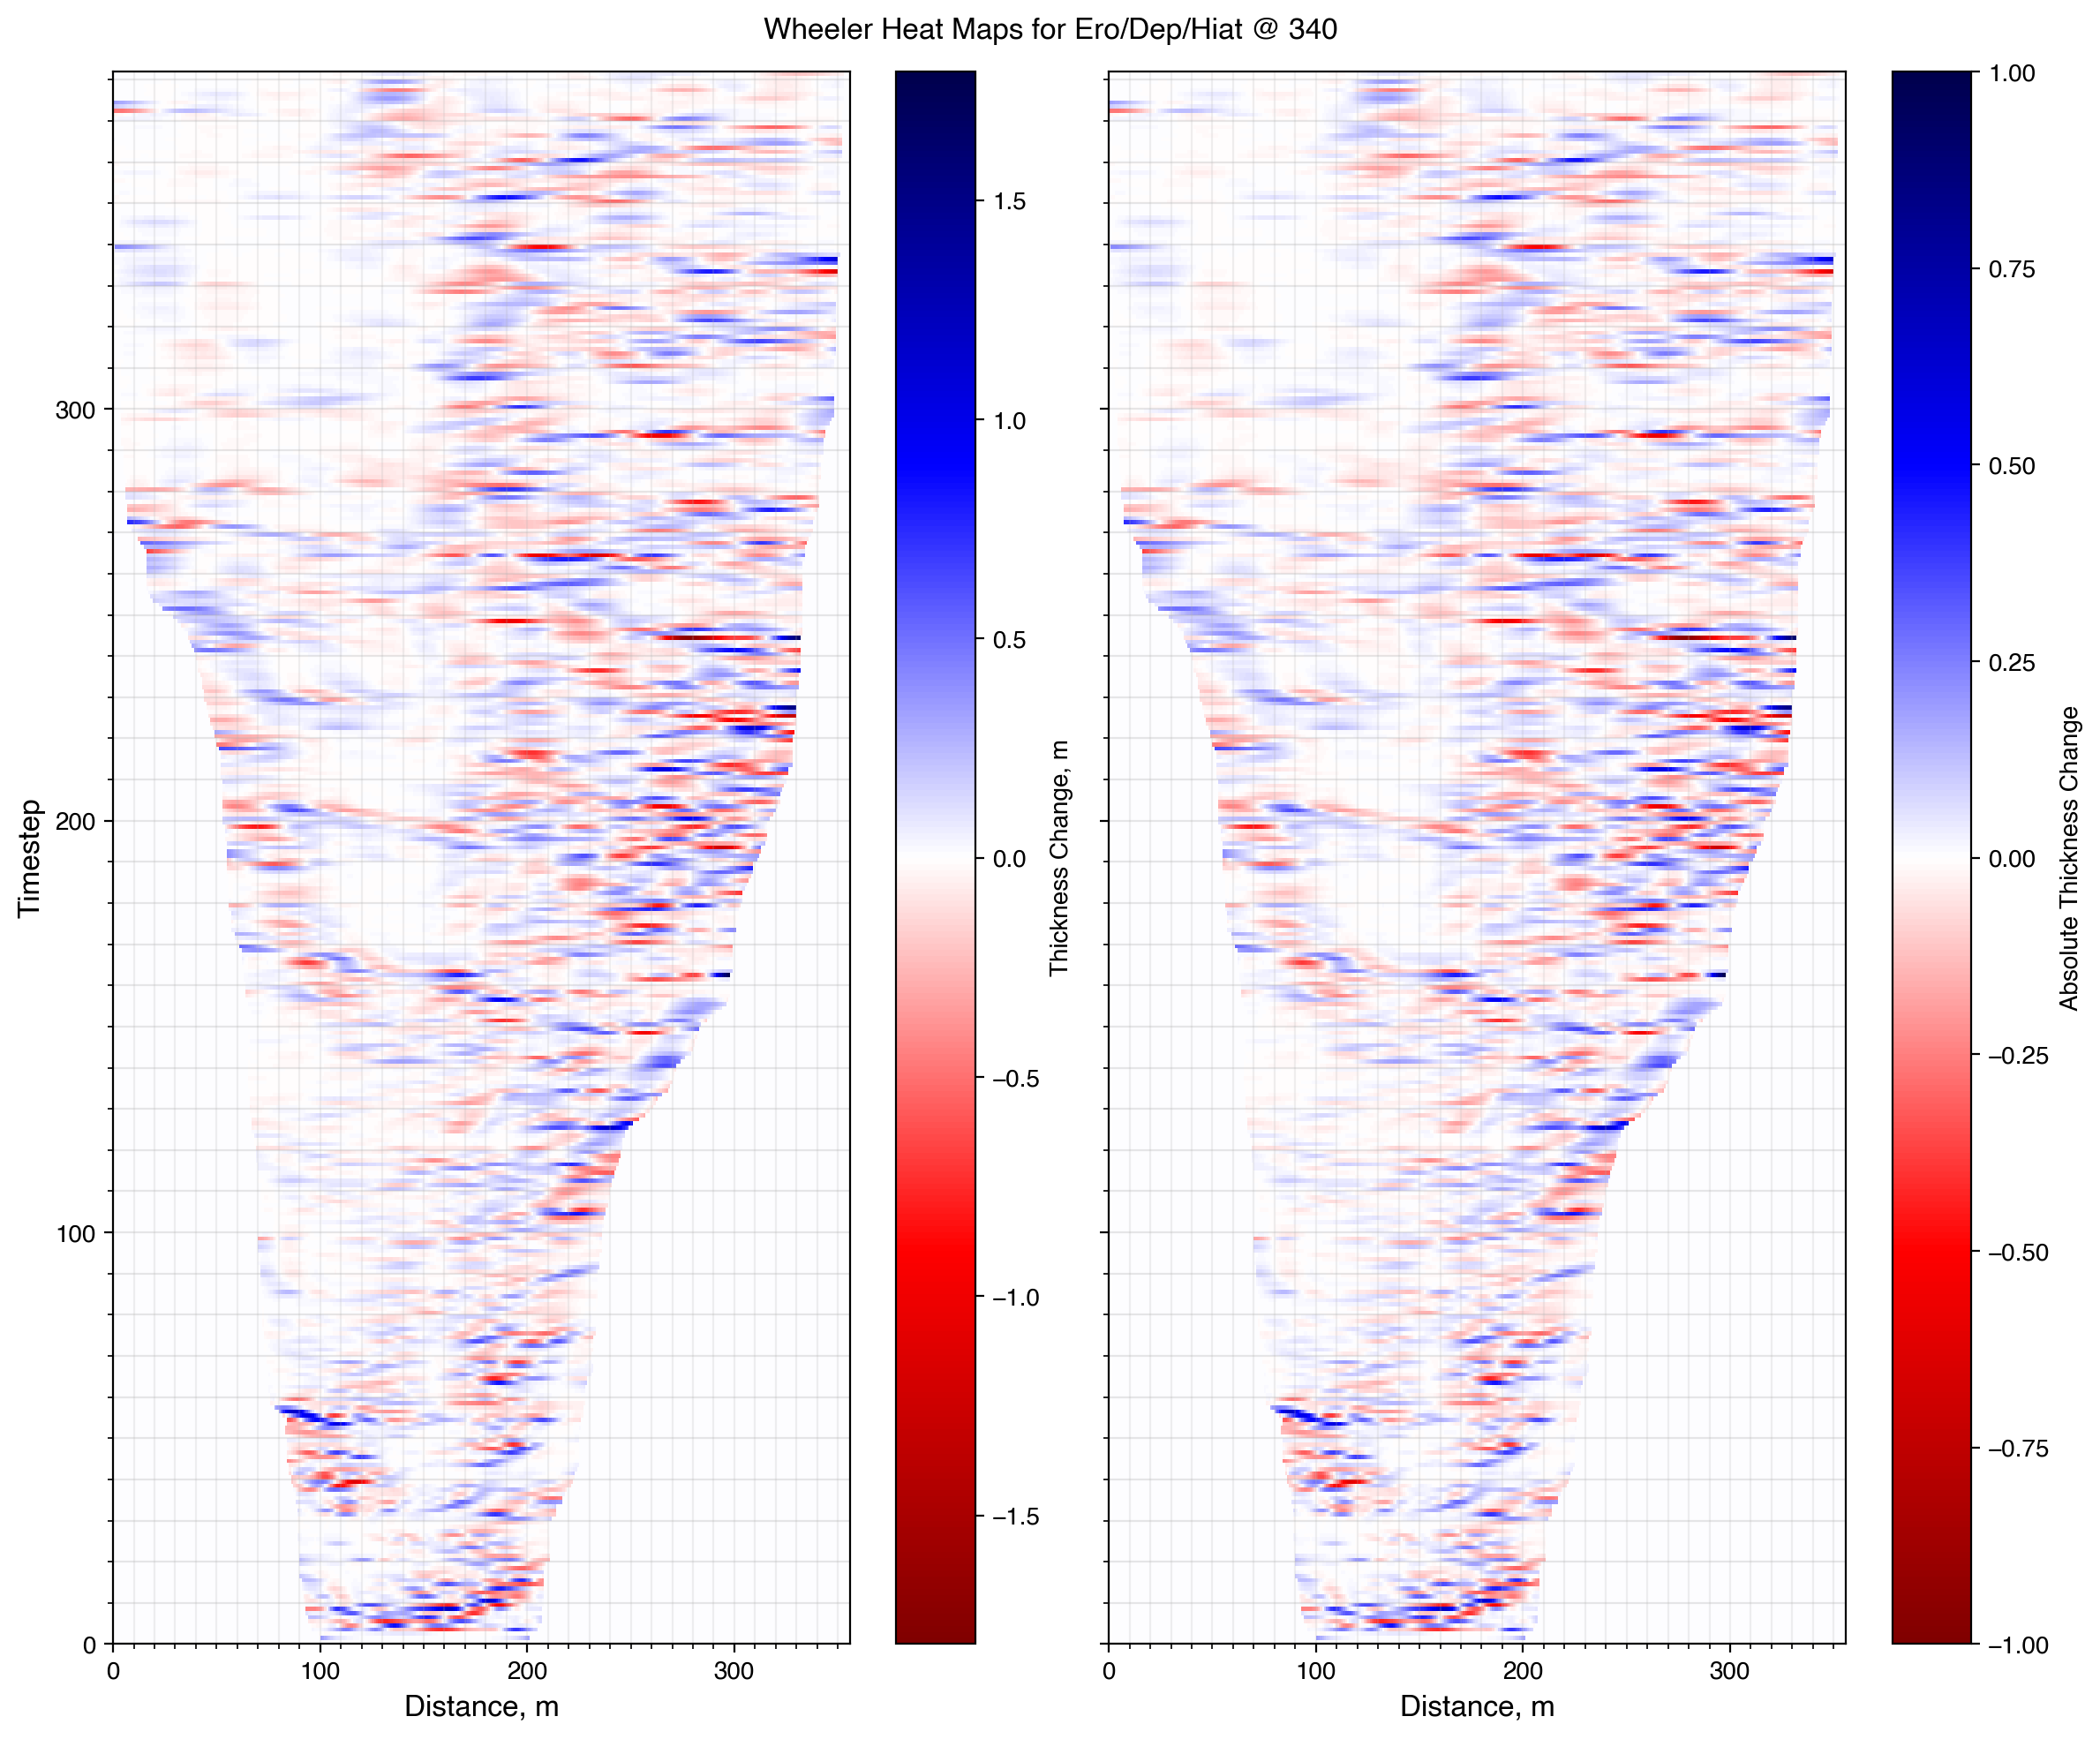

In [38]:
fig, ax = plt.subplots(1,2, figsize = (12, 10), tight_layout = True, sharex = True, sharey = True, dpi = 200)


absol = ax[0].pcolormesh(difference, cmap = 'seismic_r', norm = mcol.CenteredNorm(), shading = 'flat', snap = True)
frac = ax[1].pcolormesh(diff_fraction, cmap = 'seismic_r', norm = midnorm11, shading = 'flat', snap = True)

#absolv = ax[1,0].pcolormesh(velocub, cmap = 'YlGnBu', norm = velogradint, shading = 'flat', snap = True)
#fracv = ax[1,1].pcolormesh(vels_frac, cmap = 'YlGnBu', norm = normalise, shading = 'flat', snap = True)

#fig.colorbar()
ttl = fig.suptitle(f'Wheeler Heat Maps for Ero/Dep/Hiat @ {iloc}')
# ttl.set_position([0.5, 1.01])
#fig.tight_layout()
#fig.subplots_adjust(top=10)

fig.colorbar(absol, ax = ax[0], label = 'Thickness Change, m')
fig.colorbar(frac, ax = ax[1], label = 'Absolute Thickness Change')
#fig.colorbar(absolv, ax = ax[1,0], label = "Flow Velocity, m/s")
#fig.colorbar(fracv, ax = ax[1,1])

# ax[0].axhline(fldstart, c='k', ls = '--')
# ax[0].axhline(fldstart+fldlength/interval_to_plot, c='k', ls = '--')

# ax[1].axhline(fldstart, c='k', ls = '--')
# ax[1].axhline(fldstart+fldlength/interval_to_plot, c='k', ls = '--')

ax[0].set_ylabel('Timestep', fontsize = 12)
ax[0].set_xlabel('Distance, m', fontsize = 12)
ax[1].set_xlabel('Distance, m', fontsize = 12)
print(diff_fraction.min(), diff_fraction.max())
# plt.close(fig)

ax[0].yaxis.set_minor_locator(MultipleLocator(10))
ax[0].yaxis.set_major_locator(MultipleLocator(100))

ax[0].grid(axis = 'y', which = 'both', alpha = 0.3)

ax[1].yaxis.set_minor_locator(MultipleLocator(10))
ax[1].yaxis.set_major_locator(MultipleLocator(100))

ax[1].grid(axis = 'y', which = 'both', alpha = 0.3)

ax[0].xaxis.set_minor_locator(MultipleLocator(10))
ax[0].xaxis.set_major_locator(MultipleLocator(100))

ax[0].grid(axis = 'x', which = 'both', alpha = 0.2)

ax[1].xaxis.set_minor_locator(MultipleLocator(10))
ax[1].xaxis.set_major_locator(MultipleLocator(100))

ax[1].grid(axis = 'x', which = 'both', alpha = 0.2)

plt.savefig(savefilesto+'ero_dep_wheeler/'+modelrun+'.png', dpi = 200)


Find the left and right edges of depositional packages, append depositional matrix to get co-ordintes of rectangles for wheeler diagram.

In order for the logic statement to work to find the polygons, I created a border of nans around all ofthe arrays 

In [39]:
nan_border = np.empty([end_t, 1])
nan_border.shape
nan_border[:] = np.nan
#topointerp_nb = np.concatenate((nan_border, strat, nan_border), axis = 1) #nb = nan border
stratinterpcub_nb = np.concatenate((nan_border, xy_topo, nan_border), axis = 1)
erosurf_nb = np.concatenate((nan_border, erosurf, nan_border), axis = 1)
deposurf_nb = np.concatenate((nan_border, deposurf, nan_border), axis = 1)

hiatalsurf_nb = np.concatenate((nan_border, hiatalsurf, nan_border), axis = 1)
erohiatalsurf_nb = np.concatenate((nan_border, erohiatalsurf, nan_border), axis = 1)
posnew = np.arange(0, xy_topo.shape[1], dtype = float)
posnew_nb = np.insert(posnew, [0], [np.nan])
posnew_nb = np.insert(posnew_nb, -1, np.nan)

In [40]:
#was trying tosee if you can plot the topo at the same time of the erosion surffaces only, but the that ends up plotting all the topo
time_erohiat = np.empty_like(ages_ero) #will store only the ages of the erosional and hiatal surfaces
time_erohiat[:] = np.nan

EHindex = np.where(stratcondition != 0) #find and remove locations of deposition

time_erohiat[EHindex] = ages_ero[EHindex] #add ages to locations of erosion and hiatuses only

boundary_time_notnan = time_erohiat[~np.isnan(time_erohiat)]

boundary_time = np.unique(boundary_time_notnan)

print(boundary_time.shape)
boundary_time = np.sort(boundary_time)

#for time in boundary_time:
#    plt.plot(posnew, stratinterpcub[int(time)])

(632,)


In [41]:
depcontrol = deposurf_nb.copy()
depcontrol[~np.isnan(depcontrol)] = 1
erocontrol = erosurf_nb.copy()
erocontrol[~np.isnan(erocontrol)] = 1
#erocontrol[~np.isnan()]

##### Wheeler Diagram

In [42]:
#print(len(posnew_nb))
l_edges = np.empty([1,]) #left edge distance measure of the wheeler fill
l_index = np.empty([1,]) #index value of left edge
r_edges = np.empty([1,]) #right edge of the wheeler fill
r_index = np.empty([1,]) #index value of right edge
dep_age = np.empty([1,]) #age of each deposit for the wheeler diagram
for i in range (0,end_t):
    #if ~np.isnan(deposurf[i, 0]):
    #   rectangles[i, 0] = ages[i, 0] #if the left edge of the stratigraphy is a depositional surface

    for xpos in range (0, len(posnew_nb)-1):
        l_edge = np.all((np.isnan(deposurf_nb[i, xpos]) and ~np.isnan(deposurf_nb[i, xpos+1])))
        r_edge = np.all((~np.isnan(deposurf_nb[i, xpos]) and np.isnan(deposurf_nb[i, xpos+1])))
        
        if l_edge == True:
            l_edges = np.append(l_edges, [posnew_nb[xpos+1]], axis = 0)
            l_index = np.append(l_index, [xpos+1], axis = 0)
            #print(posnew_nb[xpos+1], 'potato')
        if r_edge == True:
            #print(xpos, 'tomato')
            r_edges = np.append(r_edges, [posnew_nb[xpos-1]], axis = 0)
            r_index = np.append(r_index, [xpos+1], axis = 0)
            dep_age = np.append(dep_age, [i], axis = 0)
        
#print('L', l_edges)
#print('R',r_edges)
#print(dep_age)

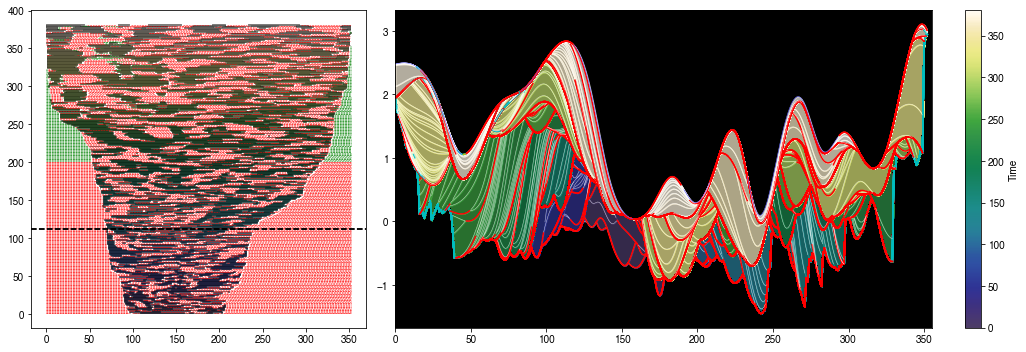

In [43]:
###Now we concatenate the L and R and age arrays to form a database to plot the rectangles
l_edges = np.reshape(l_edges, [len(l_edges), 1])
r_edges = np.reshape(r_edges, [len(r_edges), 1])
dep_age = np.reshape(dep_age, [len(dep_age), 1])

rectangles = np.empty([len(l_edges), 5])
rectangles[:, 0] = dep_age[:, 0]
rectangles[:, 1] = l_edges[:, 0]
rectangles[:, 2] = r_edges[:, 0]
rectangles[:, 3] = rectangles[:, 2]-rectangles[:, 1]
rectangles[:, 4] = 1
#print(rectangles)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5), gridspec_kw={'width_ratios': [1, 2]}, tight_layout =True)
for i in range (1, len(rectangles)):
    #rect = plt.Rectangle((rectangles[i,1], rectangles[i,0]), rectangles[i,3], rectangles[i,4], color=cpick.to_rgba(rectangles[i, 0]), ec = 'k', linewidth = 0.5)
    ax1.add_patch(plt.Rectangle((rectangles[i,1], rectangles[i,0]), rectangles[i,3], rectangles[i,4], color=cpick.to_rgba(rectangles[i, 0]), ec = 'k', linewidth = 0.5))
    
for i in range(0, end_t):
    ax1.plot(posnew_nb, i*erocontrol[i, :], 'r--', linewidth = 0.5)
    ax1.plot(posnew, i*(hiatalsurf[i, :]/hiatalsurf[i, :]), 'g--', linewidth = 0.5)
    #ax1.plot(posnew_nb, i*depcontrol[i, :], 'b.', linewidth = 0.5)

for i in range (0, end_t-1):
    ax2.fill_between(posnew, xy_topo[i+1], xy_topo[i], color=cpick.to_rgba(i), alpha = .7)
    #polys = PolyCollection.get_clip_path(self)

#Plot topo in black to find main surfaces    
for i in range (0, end_t):
    #ax1.plot(posnew, stratinterpcub[i], 'k', lw = '1', alpha = 0.1)
    ax2.plot(posnew, erosurf[i], 'r', lw='1.5', alpha = 1)
    ax2.plot(posnew, hiatalsurf[i], 'c', lw='1.5', alpha = 1)
    ax2.plot(posnew, deposurf[i], 'w', lw='0.5', alpha = 0.7)

    
ax1.axhline(fldstart, c='k', ls = '--')
ax1.axhline(fldstart+fldlength/interval_to_plot, c='k', ls = '--')

ax2.plot(posnew, erosurf[end_t-1], 'r', lw='1.5', alpha = 1)
ax2.plot(posnew, deposurf[end_t-1], 'b', lw='0.5', alpha = 0.7)
ax2.plot(posnew, hiatalsurf[end_t-1], 'y', lw='1.5', alpha = 1)
ax2.set_facecolor('k')
plt.xlim(0, posnew.max())
#plt.ylim(0, num_timesteps)
fig.colorbar(cpick,label="Time", ax=ax2, pad = 0.05)
#plt.savefig(savefilesto+'wheeler/'+modelrun+'.png', dpi = 100)
#plt.close(fig)

### Extract centroids and do preliminary statistics

In [44]:
SIC_startcrop = copy.deepcopy(xy_topo)
SIC_startcrop = np.concatenate((nan_border, SIC_startcrop, nan_border), axis = 1)

SIC_startcrop = np.delete(SIC_startcrop, 0, axis = 0)
SIC_startcrop.shape

SIC_endcrop = copy.deepcopy(xy_topo)
SIC_endcrop = np.concatenate((nan_border, SIC_endcrop, nan_border), axis = 1)

SIC_endcrop = np.delete(SIC_endcrop, -1, axis=0)
SIC_endcrop.shape

delta = SIC_startcrop-SIC_endcrop

delta[np.where(delta[:]==0)] = np.nan


##### Create the left and right vertices of each polygon

In [45]:

#print(len(posnew_nb))
#l_edges = np.empty([1,]) #left edge distance measure of the wheeler fill
l_idx = np.empty([1,]) #index value of left edge
#r_edges = np.empty([1,]) #right edge of the wheeler fill
r_idx = np.empty([1,]) #index value of right edge
surf_age = np.empty([1,]) #age of each deposit for the wheeler diagram
for i in range (0, len(delta)):
    #if ~np.isnan(deposurf[i, 0]):
    #   rectangles[i, 0] = ages[i, 0] #if the left edge of the stratigraphy is a depositional surface

    for xpos in range (0, len(posnew_nb)-1):
        l_edge = np.all((np.isnan(delta[i, xpos]) and ~np.isnan(delta[i, xpos+1])))
        r_edge = np.all((~np.isnan(delta[i, xpos]) and np.isnan(delta[i, xpos+1])))
        #print(xpos, 'L', l_edge)
        #print(xpos, 'R', r_edge)
        if l_edge == True:
            #l_edges = np.append(l_edges, [posnew_nb[xpos+1]], axis = 0)
            l_idx = np.append(l_idx, [xpos], axis = 0)
            #print(posnew_nb[xpos+1], 'potato')
            surf_age = np.append(surf_age, [i], axis = 0)
        if r_edge == True:
            #print(xpos, 'tomato')
            #r_edges = np.append(r_edges, [posnew_nb[xpos-1]], axis = 0)
            r_idx = np.append(r_idx, [xpos], axis = 0)
            
#surf_age = np.append(surf_age, [i+1], axis = 0)
#print('L', l_edges)
#print('R',r_edges)
#print(dep_age)

Store all those vertices in an array that houses the time of each polygon and the left and right edges of the poly

In [46]:
l_idx = np.reshape(l_idx, [len(l_idx), 1])
#l_index = np.delete(l_index, 1)

l_idx = l_idx.astype(int)
r_idx = np.reshape(r_idx, [len(r_idx), 1])
#r_index = np.delete(r_index, 1)
r_idx = r_idx.astype(int)

#print(l_idx[:, 0], r_idx[:, 0])
surf_age = np.reshape(surf_age, [len(surf_age), 1])

print(l_idx.shape, r_idx.shape, surf_age.shape)

vertices_b = surf_age
vertices_b = np.append(vertices_b, l_idx, axis = 1)
vertices_b = np.append(vertices_b, r_idx, axis = 1)

#print(vertices)#, vertices.shape)


cent_array = np.empty([len(vertices_b), 8])
cent_array[:] = np.nan

(533, 1) (533, 1) (533, 1)


In [47]:
##### Plot the filled stratigraphy, create a polygon for each, find the centroid, store the centroid and its age
testfig, ax1 = plt.subplots(1, 1, tight_layout=True, squeeze=True, figsize = (10,6))
poly_data = {}
for i in range (1, len(vertices_b)):
    time = int(vertices_b[i, 0])
    left = int(vertices_b[i, 1])
    right = int(vertices_b[i, 2])

    poly = ax1.fill_between(posnew[left:right], xy_topo[time, left:right], xy_topo[time+1, left:right], color=cpick.to_rgba(i))
    pverts = poly.get_paths()[0].vertices
    
    polygon = Polygon(pverts) #create a shapely polygon
    #print(polygon)
    poly_data[i] = polygon
    area = polygon.area
    bounds = polygon.bounds
    #print(type(bounds[0]))
    cent_array[i, 4] = bounds[0]
    cent_array[i, 5] = bounds[1]
    cent_array[i, 6] = bounds[2]
    cent_array[i, 7] = bounds[3]
    cent_array[i, 3] = area
    ctroid = polygon.centroid
    cent_array[i, 0] = time
    cent_array[i, 1] = ctroid.x
    cent_array[i, 2] = ctroid.y

    
    #ax1.plot(cent_array[i, 1], cent_array[i, 2], 'k*')
#ax1.set_facecolor('xkcd:midnight blue')
    

ax1.set_xlim(posnew.min(), posnew.max())
#ax1.set_ylim(xy_topo.min(), xy_topo.max())
#print('12', poly_data[12])
plt.close(testfig)
#for i in range (0, num_timesteps-1):
#   plt.plot(posnew, stratinterpcub[i, :], 'k')


remove small polygons (<nth percentile of polygon size?), generally 10th$^p$ < 0.1m$^2$ <br>
I might make this threshold 1m$^2$, so double check when doing centroid statistics

0.009385627533217523


Text(25, 40, 'n=478')

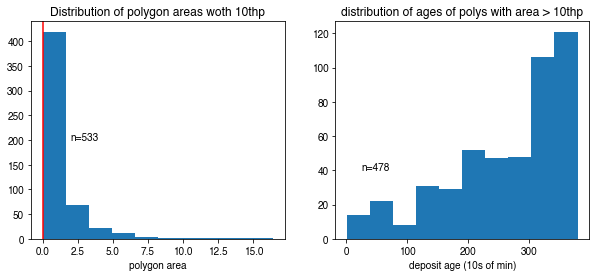

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))
#too_small_area = (cent_array[np.where(abs(cent_array[:, 3])<0.000001)])
#print(cent_array[:, 3])
ax1.hist(cent_array[:, 3])
ptile10 = np.nanpercentile(cent_array[:, 3], 10)

print(ptile10)
ax1.axvline(ptile10, c = 'r')

cent_wnan = copy.deepcopy(cent_array)
deletewhere = np.where(cent_array[:, 3] < ptile10)
cent_wnan[deletewhere] = np.nan

cent_nonan = cent_wnan[~np.isnan(cent_wnan).any(axis = 1)] #delete all rows in cent_wnan matrix with nan values

ax2.hist(cent_nonan[:, 0])
ax1.set_title('Distribution of polygon areas woth 10thp', fontsize = 12)
ax2.set_title('distribution of ages of polys with area > 10thp', fontsize = 12)
textstr1 = str(len(cent_array))
textstr2 = len(cent_nonan)
ax1.set_xlabel('polygon area')
ax2.set_xlabel('deposit age (10s of min)')
ax1.text(2, 200, 'n='+str(len(cent_array)))
ax2.text(25, 40, 'n='+str(len(cent_nonan)))
#plt.close(fig)

#### Make hero figure with strat coloured by time, showing centroids

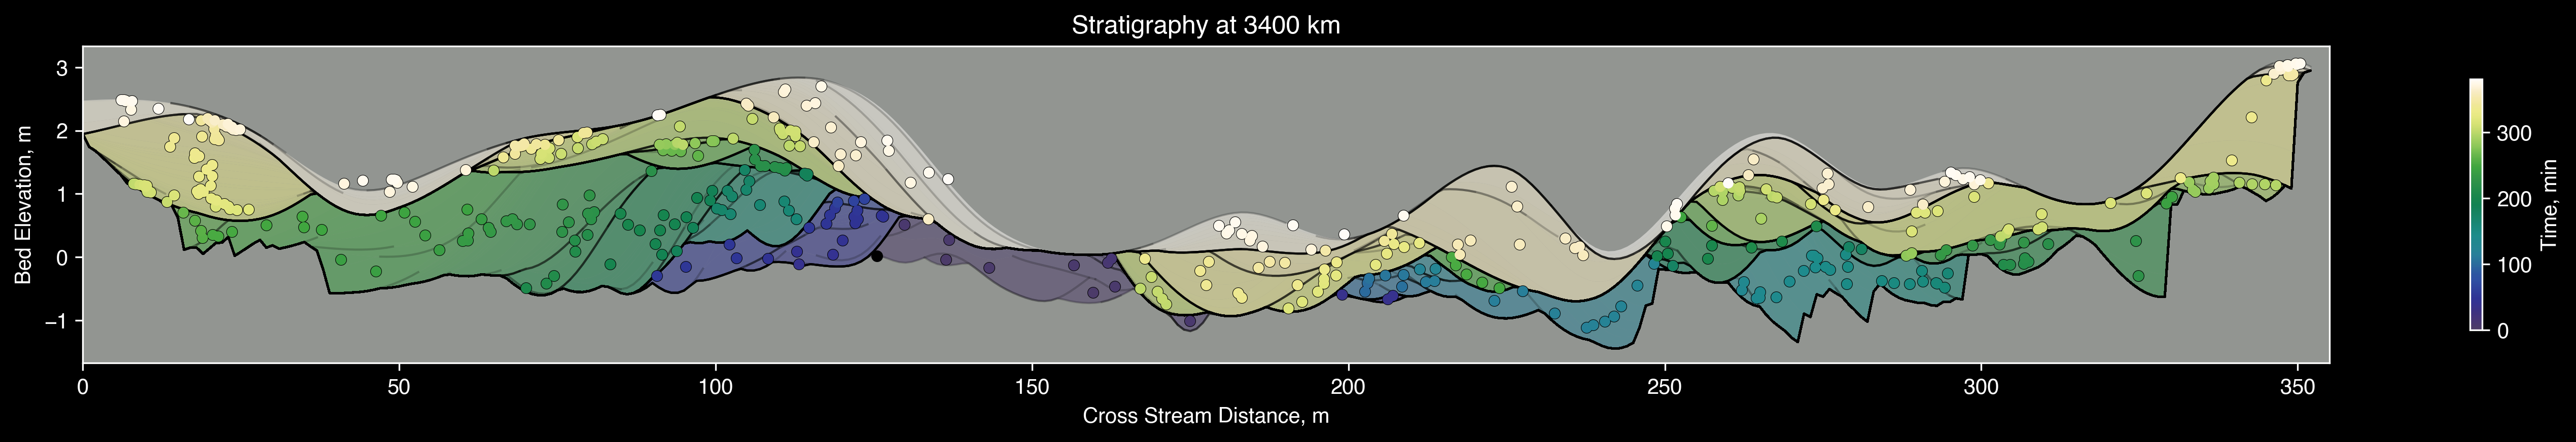

In [49]:
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1, tight_layout = True, figsize = (19.2, 3.60), dpi = 300)
    for i in range (0, end_t-1):
        #ax.plot(posnew, stratinterpcub[i], cpick.to_rgba(i), lw = 0.5, alpha = 0.4)
        ax.fill_between(posnew, xy_topo[i+1], xy_topo[i], color=cpick.to_rgba(i), alpha= 0.5, linewidth = 0.0)
        #ax.plot(posnew, erohiatalsurf[i], 'r', lw = 1, alpha = 0.5)

        #ax.plot(cent_array[i, 1], cent_array[i, 2], marker = '*', markerfacecolor = 'k', markeredgecolor = 'k', mew = .5,   ms = 4, alpha = 1)
    for i in range (0, end_t):#,5):
        #ax.plot(posnew, stratinterpcub[i], color = 'xkcd:midnight blue',  ls = '--', lw = .8, alpha = .3)
        #ax.plot(cent_wnan[i, 1], cent_array[i, 2], marker = '.', markerfacecolor = cpick.to_rgba(cent_array[i, 0]), markeredgecolor = 'k', mew = .1,   ms = 5, alpha = 1)
        ax.plot(posnew, erohiatalsurf[i], 'k', lw = 1, alpha = .2)
    for i in range (1, len(vertices_b)):
        ax.plot(cent_wnan[i, 1], cent_wnan[i, 2], marker = 'o', markerfacecolor = 'k', markeredgecolor = 'k', mew = .5,   ms = 5, alpha = 1)
    for i in range (1, len(cent_nonan)):
        ax.plot(cent_nonan[i, 1], cent_nonan[i, 2], marker = 'o', color = cpick.to_rgba(cent_nonan[i, 0]), markeredgecolor = 'k', mew = .0,   ms = 5, alpha = 1)

    ax.set_facecolor('xkcd:grey')
    fig.colorbar(cpick,label="Time, min", ax=ax, shrink=0.5)
    #ax.set_xlim((200, 300))
    ax.set_xlim(posnew.min(), posnew.max())
    #ax.set_ylim(xy_topo.min(), xy_topo.max())
    ax.set_aspect(10)
    ax.set_xlabel('Cross Stream Distance, m')
    ax.set_ylabel('Bed Elevation, m')
    #cpick.to_rgba(cent_wnan[i, 0]), marker color by time
    #ax.set_ylim(stratinterpcub.min(), stratinterpcub.max())
    plt.title(f'Stratigraphy at {iloc*10} km')
#plt.savefig(savefilesto+'herofig/'+modelrun+'.png', dpi = 300)
#plt.close(fig)

#### Extract polygon statistics for the new, reduced centroid array

Data in each column is as follows: <br>
<ol start="0">
  <li>Age</li></ol>

1. cent x (1), 
2. cent y (2), 
3. cent area (3), 
4. pol minx (4), 
5. pol miny (5), 
6. pol maxx (6), 
7. pol maxy (7), 
8. pol width (8),
9. pol heigt (9), 
10. distance (10),
11. reltime (11),
12. delx (12), 
13. dely (13)

In [50]:
print(cent_nonan[:5, 4])
print(cent_nonan[:5, 6])
poly_widths = cent_nonan[:, 6]-cent_nonan[:, 4]
poly_widths = np.reshape(poly_widths, [len(poly_widths), 1])

poly_heights = cent_nonan[:, 7]-cent_nonan[:, 5]
poly_heights = np.reshape(poly_heights, [len(poly_heights), 1])
#print(poly_widths.shape)

cent_nonan = np.concatenate((cent_nonan, poly_widths, poly_heights), axis = 1)

[125. 134. 155. 125. 129.]
[126. 139. 166. 159. 146.]


In [51]:
## find lendth and width of the final topography
range_x = position.max()-position.min()
range_y = np.nanmax(xy_topo)-np.nanmin(xy_topo)
print(range_x, range_y)

355.0 4.553140893420537


Distance between centroids, time between consecutive centroids and the distance moved relative to the channel width and height

In [52]:
dists = np.zeros([len(cent_nonan[:, 3]), 1])
reltime = np.zeros([len(cent_nonan[:, 3]), 1]) #will store the elapsed time between two consecutive centroids
delx = np.zeros([len(cent_nonan[:, 3]), 1])
dely = np.zeros([len(cent_nonan[:, 3]), 1])

for i in range (0, len(cent_nonan)-1):
    dists[i, 0] = ((cent_nonan[i+1, 1]-cent_nonan[i, 1])**2+(cent_nonan[i+1, 2]-cent_nonan[i, 2])**2)**0.5
    reltime[i,0] = cent_nonan[i+1, 0]-cent_nonan[i, 0]
    delx[i, 0] = abs(cent_nonan[i+1, 1]-cent_nonan[i, 1])/range_x
    dely[i, 0] = abs(cent_nonan[i+1, 2]-cent_nonan[i, 2])/range_y
cent_nonan = np.concatenate((cent_nonan, dists, reltime, delx, dely), axis = 1)
print(cent_nonan.shape)

(478, 14)


In [53]:
delx = np.delete(delx, -1, axis=0)
dely = np.delete(dely, -1, axis=0)

##### SAVE CENTROIDS

In [54]:
#np.save(f'/Volumes/SAF_MSCWORK/Python/Stratigraphy/Data/nparrays/centroids/{arrayfolder}/c{iloc}', cent_nonan)

**Plot some histograms to look at the preliminary data**

Text(0.5, 0.98, 'I = 340 n=478')

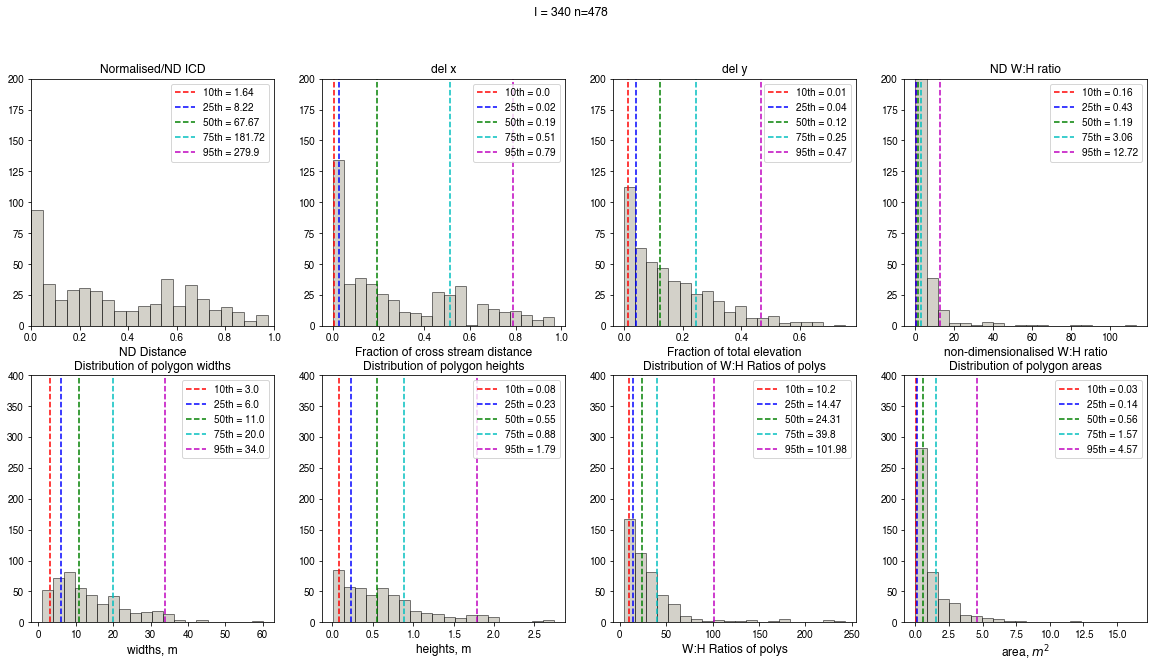

In [55]:
nbins = 1+3.122*math.log(len(cent_nonan), 10)
nbins = np.round(nbins, 10)

fig, ax = plt.subplots(2,4, figsize = (20,10))

##### del ICD
deldist = (delx**2+dely**2)**0.5
ax[0,0].hist(deldist, **kwargs)
ax[0,0].set_title('Normalised/ND ICD', fontsize = 12)
ax[0,0].set_xlabel('ND Distance',  fontsize = 12)
ax[0,0].set_ylim(0, 200)
ax[0,0].set_xlim(0, 1)
##### del x
ax[0,1].hist(cent_nonan[:, 12], **kwargs)
ax[0,1].set_title('del x',  fontsize = 12)
ax[0,1].set_xlabel('Fraction of cross stream distance',  fontsize = 12)
ax[0,1].set_ylim(0, 200)
##### del y
ax[0,2].hist(cent_nonan[:, 13],  **kwargs)
ax[0,2].set_title('del y',  fontsize = 12)
ax[0,2].set_xlabel('Fraction of total elevation',  fontsize = 12)
ax[0,2].set_ylim(0, 200)
##### distance in terms of del x and del y
#
delxdely = delx/dely
ax[0, 3].hist(delxdely,  **kwargs)
ax[0, 3].set_title('ND W:H ratio',  fontsize = 12)
ax[0, 3].set_xlabel('non-dimensionalised W:H ratio',  fontsize = 12)
ax[0, 3].set_ylim(0, 200)
##### polygon widths
ax[1,0].hist(cent_nonan[:, 8],  **kwargs)
ax[1,0].set_title('Distribution of polygon widths', fontsize = 12)
ax[1,0].set_xlabel('widths, m',  fontsize = 12)
ax[1,0].set_ylim(0, 400)
#polygon heights
ax[1,1].hist(cent_nonan[:, 9], **kwargs)
ax[1,1].set_title('Distribution of polygon heights', fontsize = 12)
ax[1,1].set_xlabel('heights, m',  fontsize = 12)
ax[1,1].set_ylim(0, 400)
#polygon w:H ratio
ax[1,2].hist(cent_nonan[:, 8]/cent_nonan[:, 9], **kwargs)
ax[1,2].set_title('Distribution of W:H Ratios of polys', fontsize = 12)
ax[1,2].set_xlabel('W:H Ratios of polys',  fontsize = 12)
ax[1, 2].set_ylim(0, 400)
##### polygon areas
ax[1, 3].hist(cent_nonan[:, 3], **kwargs)
ax[1, 3].set_title('Distribution of polygon areas',  fontsize = 12)
ax[1, 3].set_xlabel('area, $m^2$',  fontsize = 12)
ax[1, 3].set_ylim(0, 400)

ptiles = np.array([10, 25, 50, 75, 95])
ptile_store = np.empty([8, len(ptiles)])

indexlist = [cent_nonan[:, 10], cent_nonan[:, 12], cent_nonan[:, 13], delxdely, cent_nonan[:, 8], cent_nonan[:, 9], cent_nonan[:, 8]/cent_nonan[:, 9],cent_nonan[:, 3]]
colours = ['r', 'b', 'g', 'c', 'm', 'y', 'k']
ax = ax.ravel()

for i in range(0, len(ax)):

    ptile_store[i, :] = np.percentile(indexlist[i], ptiles)
    for j in range (0, len(ptiles)):
        ax[i].axvline(ptile_store[i, j], c = colours[j], ls = '--', label = str(ptiles[j])+'th = '+ str(round(ptile_store[i, j], 2))) 
        #ax[i].axvline(ptile_store[i, j], c = 'b', ls = '--', label = '25th = '+ str(round(icd_ptiles[1])))
        #ax[i].axvline(ptile_store[i, j], c = 'g', ls = '--', label = '50th = '+ str(round(icd_ptiles[2])))
    ax[i].legend()
#icd_ptiles = np.percentile(cent_nonan[:, 10], [10, 25, 50])

#print(icd_ptiles)
#p10 = ax[0, 0].axvline(icd_ptiles[0], c = 'r', ls = '--', label = '10th = '+ str(round(icd_ptiles[0]))) 
#p25 = ax[0, 0].axvline(icd_ptiles[1], c = 'b', ls = '--', label = '25th = '+ str(round(icd_ptiles[1])))
#p50 = ax[0, 0].axvline(icd_ptiles[2], c = 'g', ls = '--', label = '50th = '+ str(round(icd_ptiles[2])))


icd_norm = cent_nonan[:, 10]/ptile_store[0, 0]

#ax[1, 0].hist(icd_norm, bins = nbins)
#ax[1,0].set_title('Normalised ICD',  fontsize = 12)
#ax[0,0].text(20, 50, 'n='+str(len(cent_nonan)))



fig.suptitle('I = '+str(iloc)+' n='+str(len(cent_nonan)))
#plt.savefig(savefilesto+'stats/'+modelrun+'.png', dpi = 100)

### Nearest neighbour type algo to group centroids by their spacing
my version of a nearest neighbourish regression to find neighbourhoods of centroids that formed at the same time close to eachother (ideally, these would be formed in the same package)
potentially useful for mapping persistence?

In [56]:
centroids = np.append(cent_nonan, np.zeros([len(cent_nonan), 1]), axis=1)
hoods = np.empty([1, 3]) #will hold the neighbourhoods the centroids could fall into and the age of the centroid
hoods[0] = centroids[0, :3]

thresh = np.median(dists) #50 #distance threshold to call it a neighbour
print('ICD Threshold is: ', thresh)
for i, age in zip(range(1, len(centroids)), centroids[1:, 0]):
    #print('*******age: ', age, '******** i: ', i)
    potential_hoods = hoods[np.isclose(hoods[:, 0], age, atol=2)]
    
    #print('I: ',i, ' age: ', ' hood: ', potential_hoods)
    if len(potential_hoods) == 0:
        hoods = np.append(hoods, np.reshape(centroids[i, :3], [1, 3]), axis=0) #create new hood with cent x, y and age
        centroids[i, -1] = centroids[i, 0] #add new hood zipcode zipcode column (last column)
        #print('no existing hood is good, new hood ->', hoods.shape)
    else: 
        potential_hoods = np.reshape(potential_hoods, [len(potential_hoods), 3])    
        #print(i, potential_hoods)
        #print(potential_hoods.shape)
        #print(np.where(np.isclose(hoods[:, 0], age, atol=5)))
        #potential_hoods = np.resha
        #print('ph', potential_hoods)
        distances = np.array([])
    
    
        #test each potential hood for distance
        for row in potential_hoods:
        
            dist = ((centroids[i, 1]-row[1])**2 + (centroids[i, 2]-row[2])**2)**0.5
            distances = np.append(distances, dist)
        #print('dist shape', distances.shape, )
            #find nearest neighbour, append or make ner neighbourhood
    
        mindist = distances.min() #ifind minimum calculated distance between point and all potential neighbours
        potenti = potential_hoods[np.where(distances==mindist)]
        #print('potenti shape: ', potenti.shape)
        #print('Mini dist: ', mindist,'potential neighbourhoods: ', potenti)
        #print(distances)
        if (mindist < thresh) & np.isclose(potenti[:, 0], age, atol=2) : 
            md_hood = np.where((hoods[:, :3] == potenti).all(axis=1))
            #print('equal at: ', md_hood)
            hoods[md_hood, 1:] = potenti[:, 1:]
            centroids[i, -1] = hoods[md_hood, 0]
            #print(centroids[:i+1, -1])
        elif mindist > thresh:
            hoods = np.append(hoods, np.reshape(centroids[i, :3], [1, 3]), axis=0)
            centroids[i, -1] = centroids[i, 0]
            #print('Too far from everything, make new hood, it = ', i, hoods.shape)

ICD Threshold is:  67.66734058110556


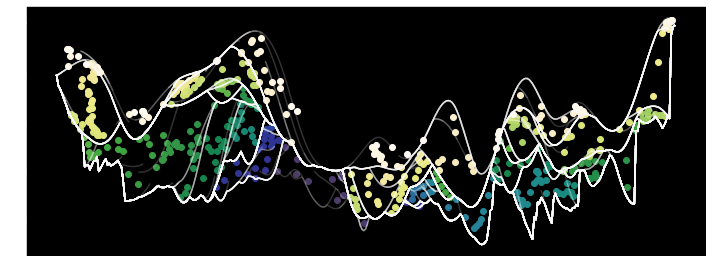

In [57]:
fig = plt.figure(figsize = (10, 4), tight_layout = True)

plt.style.use('dark_background')
for i in range(0, len(centroids)):
    plt.plot(centroids[i, 1], centroids[i, 2], color = cpick.to_rgba(centroids[i, -1]), marker = 'o')
for i in range (0, end_t):
    plt.plot(erohiatalsurf[i], 'w', alpha = 0.2)


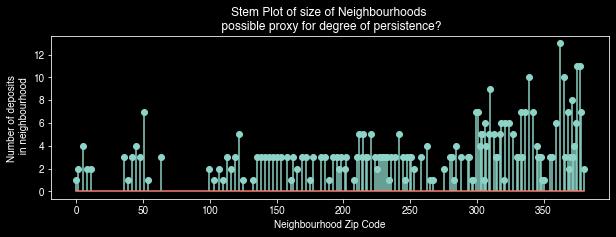

In [58]:
###look at/calculate residence time/reworking tme 
fig = plt.figure(figsize = (10, 3))
numneighbs = collections.Counter(centroids[:, -1])
plt.stem(numneighbs.keys(), numneighbs.values())
plt.title('Stem Plot of size of Neighbourhoods \n possible proxy for degree of persistence?');
plt.xlabel('Neighbourhood Zip Code')
plt.ylabel('Number of deposits \n in neighbourhood')
neighb_list = collections.Counter(centroids[:, -1]).most_common()
# print(neighb_list)

**This is just a check to see if the neighbourhood code works correctly** <br> Pick a neighbourhood and plot the centroids in that neighbourhood and the ages of the centroids in that neighbourhood.

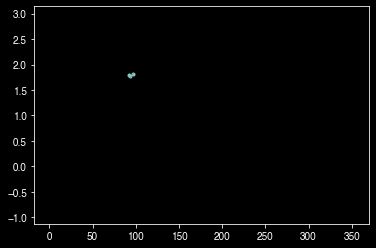

In [59]:
tn = 280 #test neighbourhood number
intn = centroids[:, 0][centroids[:, -1]==tn].astype('int')
plt.plot((centroids[:, 1][centroids[:, -1]==tn]), (centroids[:, 2][centroids[:, -1]==tn]), '.')
for i in intn:
    plt.plot(posnew, xy_topo[i], 'k', lw = '0.1')

### Compare shape trends across the reach (for XS) 
*to run this you'll have to have already run the StratBuilder_buildchannelwidths code* ~add links
- width and widening rate across the reach
- CV and SD of bed elevation (time series)
- and some other shit


In [60]:
reach_raw = np.load(f'/Volumes/SAF_Data/NAYS2DH_files/Data/chan-widths/CW-{datnam}')
reach_raw = reach_raw[:, :, :num_timesteps]
##### create array to store the statiistics on the channel width for the full reach 
##### This is a end_t x 3 array with min, max and mean reach width
max_chw = reach_raw[:, 2].max(axis=0)
min_chw = reach_raw[:, 2].min(axis=0)
reach_raw = np.concatenate((reach_raw, np.empty([len(reach_raw), 1, end_t])), axis = 1)
print(reach_raw.shape)
for i in range (0, end_t-1):
    reach_raw[:, 3, i] = (reach_raw[:, 2, i+1]-reach_raw[:, 2, i])/interval_to_plot #find and append reach data with widening rate, PER HOUR
    

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/SAF_Data/NAYS2DH_files/Data/chan-widths/CW-0hfld-datamaster-2hour-ud.npy'

In [ ]:
## Look at time series of widening rates in the section
if sec_flag == 'XS':
    widths = xposition.max(axis = 1)-xposition.min(axis = 1)
    times = np.arange(0, end_t*interval_to_plot, interval_to_plot)
    rate = np.empty([end_t, 3])
    rate[:] = np.nan

    floodzone = mpl.patches.Rectangle((fldstart, widths.min()), fldlength/interval_to_plot, max_chw.max()-min_chw.min(), color = 'xkcd:sea blue', alpha = 0.1, label = 'Flooding')


    for i in range(0, end_t-1):
        rate[i, 0] = (widths[i]-widths[i+1])/(times[i]-times[i+1])
        rate[i, 1] = reach_raw[:, 3, i].min()
        rate[i, 2] = reach_raw[:, 3, i].max()
        #print(rate[i])
    fig, ax = plt.subplots(figsize = (10, 6), tight_layout = True)
    ax.plot(times, widths, c = 'r', ls = '--', marker='.', mfc = 'r', mec = 'k', mew = 0, label = 'section width')


    ax.add_patch(floodzone)
    ax.axvline(fldstart, c = 'xkcd:sea blue', ls = '--')
    ax.axvline(fldstart+fldlength/interval_to_plot, c = 'xkcd:sea blue', ls = '--')
    ax.fill_between(times, min_chw, max_chw, color = 'xkcd:stone', alpha = 0.3, label = 'Min/Max of reach')
    ax2 = ax.twinx()
    ax2.plot(times, thickness.max(axis = 1)/times, c = 'xkcd:black', ls = '--', marker='.', mfc = 'k', mec = 'k', mew = 0.3, label = 'Max thickness')
    ax2.plot(times, thickness.min(axis = 1)/times, c = 'xkcd:steel grey', ls = '--', marker='.', mfc = 'xkcd:steel grey', mec = 'xkcd:steel grey', mew = 0, label = 'Min thickness')
    ax2.plot(times, np.mean(thickness, axis = 1)/times, c = 'xkcd:cerise', marker='.', mfc = 'xkcd:cerise', mec = 'k', mew = 0, label = 'Mean thickness')

    ax.set_ylim(min_chw.min(), max_chw.max())
    ax.set_xlim(0, end_t)
    ax.set_ylabel('Channel Width, m')
    ax.set_xlabel('Timestep')
    ax2.set_ylabel('Bed thickness, m')
    plt.title('The question is: Will these trends hold for variable discharge')
    ax.legend(loc = 'upper left')
    plt.legend(loc = 'best')
    #plt.savefig(savefilesto+'widths/'+modelrun+'.png', dpi = 100)

    fig, ax = plt.subplots(1, figsize = (7, 3), tight_layout=True)
    ax.plot(times, rate[:, 0], 'r', ms = '5', mec = 'r', mfc = 'k', label = 'Section Widening Rate')
    ax.fill_between(times, rate[:, 1], rate[:, 2], color = 'xkcd:stone', alpha = 0.3, label = 'Min/Max of reach')
    ax.axvline(fldstart*interval_to_plot, c = 'xkcd:sea blue', ls = '--', alpha = 0.5)
    ax.axvline(fldstart*interval_to_plot+fldlength, c = 'xkcd:sea blue', ls = '--', alpha = 0.5)
    #ax.legend()
    ax.set_ylim(-20, 20)
    ax.set_title(f'Widening trends aong the reach compared to section at {iloc*cellL} m')
    ax.set_ylabel('Widening Rate, m/hr')
    ax.set_xlabel('Time, hr intervals')

#plt.savefig(savefilesto+'widths/rate'+modelrun+'.png', dpi = 100)

In [ ]:
coev_bedelev = stats.variation(strat, axis = 1, nan_policy='omit') ###gives wonky values, using SD because it is normalised to N and the mean also
sd_bedelev = np.nanstd(strat, axis = 1)

coev_reach = stats.variation(datamaster[:, 7, :], axis = 0)
sd_reach = np.std(datamaster[:, 7, :], axis = 0)

### If we want to accurately compare the reach statistics to the channel section, we need to be comparing the reach data

#### some essays
So for centroid mapping and statistics on the final stratigraphy, we need to be looking at this code with the xy_topo data but for true comparison and building these types of time series on the bed statistics, we need to be using the datamaster, not the xy_topo because that preserves only the final data

But actually, maybe we can use strat because strat is uneroded.... Yes, we can use strat.

fig, ax = plt.subplots(2, figsize = (12, 8), tight_layout = True)

ax[0].plot(rate[:, 0], c = 'r', ls = '--', marker='.', mfc = 'r', mec = 'k', mew = 0, label = 'rate')
ax2 = ax[0].twinx()
ax2.plot(times/2, sd_bedelev, 'b.', label = 'SD Bed Elev')
ax2.plot(times/2, coev_bedelev, 'k.', label = 'CV Bed Elev')
ax[0].fill_between(times/2, rate[:, 1], rate[:, 2], color = 'xkcd:stone', alpha = 0.3, label = 'Min/Max of reach')

ax[0].set_ylabel('Channel Widening Rate, m/timestep')
ax[0].set_title('Widening and SD of bed elevation, IN SECTION')

ax[0].legend(loc='right')
ax2.legend(loc = 'best')

#ax[0].axvline(fldstart, c = 'b', ls = '--')
#ax[0].axvline(fldstart+fldlength/interval_to_plot, c = 'b', ls = '--')

ax[1].set_title('Distribution of bed elevations before and immediately after flood \n Inset showing bed elevation pre and post flood')
axins = inset_axes(ax[1], width=3, height=1)
ax[1].hist(strat[pref_idx, :], **kwargs, label = 'Pre-Flood Hist')
ax[1].hist(strat[post_idx, :], histtype = 'step', bins = 20, lw = 2, ec = 'k', label = 'Post-Flood Hist')

axins.plot(strat[pref_idx, :], c = 'xkcd:greyish')
axins.plot(strat[post_idx, :], c = 'b')
axins.set_ylabel('Bed Elev')
axins.set_xlabel('XSD, m')

ax[1].set_ylabel('Count')
ax[1].set_xlabel('Bed Elevation, m')
ax[1].legend(loc='upper left')

plt.savefig(savefilesto+'centstats/WSD'+modelrun+'.png', dpi = 100)

plt.subplots(figsize = (10, 4), tight_layout = True)

plt.plot(times/2, np.nanmin(shear, axis = 1), c = 'xkcd:grey', marker = 'v', lw = 0.0, label = 'Min shear')
plt.plot(times/2, np.nanmax(shear, axis = 1), c = 'b', marker = '^', lw = 0, label = 'Max shear')
plt.plot(times/2, np.nanmean(shear, axis = 1), c = 'k', marker = '.', lw = 0, label = 'mean shear')
plt.axvline(fldstart, c = 'b', ls = '--')
plt.axvline(fldstart+fldlength/interval_to_plot, c = 'b', ls = '--')

plt.plot(times/2, rate[:, 0], 'r--', label = 'Wide rate')
plt.ylabel('Bed Shear Stress, Nm/2')
plt.xlabel('Timestep, 2hour')
plt.title('Comparison between bed shear stress and channel widening rate \n null--widening and shear stress drops should occur together')
plt.legend()
plt.savefig(savefilesto+'centstats/SSvW'+modelrun+'.png', dpi = 100)

fig, ax = plt.subplots(figsize = (12, 6), tight_layout=True)

ax.plot(rate[:, 0], c = 'r', ls = '--', marker='.', mfc = 'r', mec = 'k', mew = 0, label = 'rate')
ax2 = ax.twinx()

ax.fill_between(times/2, rate[:, 1], rate[:, 2], color = 'xkcd:stone', alpha = 0.3, label = 'Min/Max of reach')

ax.set_ylabel('Channel Widening Rate, m/timestep')

ax2.plot(times/interval_to_plot, sd_bedelev, 'k.', label = 'SD of x section')
ax2.plot(times/interval_to_plot, sd_reach, '.', c = 'xkcd:grey', label = 'SD of entire model domain', alpha = 0.5)

ax2.set_xlabel('timesteps (2 hours)')
ax2.set_ylabel('CV')
plt.title('CV bed elev of reach compared to XS')
plt.legend(loc='lower right')

ax.axvline(fldstart, c = 'b', ls = '--')
ax.axvline(fldstart+fldlength/interval_to_plot, c = 'b', ls = '--')
#ax2.set_ylim(0, 1.5)

axins1 = inset_axes(ax, width=3.5, height=1.5, loc ='upper left')
axins1.plot(times/interval_to_plot, np.nanmean(xy_topo, axis = 1), 'k--')
axins1.plot(times/interval_to_plot, coev_reach, 'b--')

plt.plot(np.log(times/interval_to_plot), np.log(sd_reach))

### Auto-picker for picking the main bounding surfaces--and some essays

###### A overly wordy note on pervasive surfaces of erosion and non-depositon...

22/01/2021

(tl;dr) Skip to the 5th paragraph for the code logic, paragraphs 1-5 are sort of an amuse-bouche:

Okay, I spent the last coupe of weeks tinkering with different methods of picking out the mot pervasive/prominent/erosiva/longest non-depositional surfaces in the stratigraphy and it feels immensely complicated. I've tried multiple methods that are equally shitty, but some have their own advantages. 

In an ideal case, I'd be able to lot out entire, through-going and complete surfaces at each timestep that repesent the major bounding surfaces in the stratigraphy after the end of the entire model run. I have, to this date, never seen this done in a paper. The closest to this was the extracion of surfaces of erosion in Wietse Van de Lageweg's dissertation (Chapter 5, also published in 2014ish, its a sedimentology paper i think). Being able to pull out these surfaces is important becuse they most likely represent the best (quality and quantity) resolution of the internal evolution of the channel belt that we may be able to capture in the feld, so naturally, we would want to compare the model stratigraphy at this similar scale. 

The problem I'm having is that I only have piecemal locations of erosion and non-deposition that do not make complete surfaces on the plots, ergo I cannot create polygons (read: bar packages) to get various statistics from the model stratigraphy. No statistics == No thesis == Stuck in State College forever (only a little bit melodramatic here, if you are reading this and you are not Safiya, I apologise, unless you find this rant amusing. I hope you do. Sorry for the digression, anyway back to extracting the most prominent bar packges from the model stratigraphy...). In an ideal case I would be able to (and sorry this is essentially a figure so I am thinking like a graphic artist/GIS person here) plot all the piecemal erosion and hiatal surfaces on a plot that is technically 3D (x-y-time) as I plotted it using a for loop then flatten the plot onto only the x-y dimension, then I would have essentially a polyline (I think, idk what a polyline is tbh, but essentially I'd have a complex shape made up of multiple polygons..maybe I'll have a muiltipolygon idk) which I could transfer to another software package (maybe Petrel, Arc, Photoshop, ImageJ or something) and extract the dimesions and attributeds of the polygons, get my statistics and graduate (or publish, who know's what future Saf will do). There are two problems with this approach:

1. I do not know how to do that, and I worry that the exercise in figuring it out will literally take all of the power my two brain cells possess and take literally forever because I ain't no coder and have yet to find a comp scientist that can help with this problem in a *helpful* way. 
2. This mightn't even be beneficial because then we will have the same problem of assessing the universiality of image based statistical approaches to building statistics like this (re Ellen and Liz stick model avulsion problems with relating model space to field space) and all of my years of furious stack exchange searches will be a (comparative) waste
    
With this in mind, I am trying to adopt a vector-based, pseudo-statistical approach to figure put exactly which surfaces will statistically get preserved in outcrop (omfg I could literally write a paper on this but again I digress...). I've tried a couple ways to get this going in the cells that follow, using the array that stores the ages of all surfaces of the stratigraphy (ages_ero). This array accounts for resetting of the age of a deposit when it is eroded and also for when there is non-deposition (hiatus):

<u>Approach 1: </u> Non-normalised, high-frequency surfaces
In this method I plot the frequency of the ages of the aurfaces in the straitgraphy assuming that more pervasive and persistence surfaces will have higher frequencies. We want to then know what the distribution of frequencies looks like. Essentially we want the freuqncies that are the outliers, the things that are more frequent than anything else, these are, theoretially correspodent to erosion surfaces that rework the most stratigraphy or hiatal surfaces that receive no deposition for the longest time. When building the aes_ero matrix, these are the surfaces that get reset the most therefore should have an inordinately high frequency. I then create set of quantiles that we want (that in this case specify te degree of eworking/non-depositing at the surface), for this case I use the 75th, 80th, 85th and 90th. I plot the ages (read: timesteps) that correspond to those quantiles, and compare the resultant stratigraphy to that which is output when I plot the erohiatalsurfs only. This method is ok, however it doesn't cover some of the earlier surfaces since either (1) the 'area' that is available to be reworked at a time is much less than that available at a later time, say comparing erosion at timestep 25 having '25 x posnew' number of locations for erosion vs timestep 200 with '200 x posnew' locations to erode (assuming even deposition everyhere between those time maybe. I'm hoping you understand how this might be problematic. But somehow it kinda works, it seems like consistently, surfaces above the 85th ish percentile best for the erohistalsurf surfaces, which is interesting. 

<u>Approach 2: </u> Normalised, high-frequency surfaces
This is the same method as Approach 1 except I normalise the Frequency of ages in the ages_ero matrix to the area available for erosion at each timestep. Theoretically this would give us a more representative distribution of the most erosive surfaces but so far it just skewes the histogram to the left (aggressively) and almost all of the surfaces become insignificant (excl the initial surface and the final one)

<u>Approach 3: </u>Most continuous erosion surfaces
Here I found the count of the number of points of erosion/non-deposition at each timestep with the hypothesis that the surfaces that were the most pervasive and persistent were the ones that resampled the most stratigrahy therefore the count of non-nan elements in the array should be highest in the important surfaces (again using quantiles). There are a couple problems with this but the most significant is that erosion surfaces are not always the same age  so when you sum the non-nan elements it's not entirely an accurate representation and it isqute unlikely that a surface across the entire cross section is an erosion surface, meaning that we get alo the bits of the surface that are depositonal and that does not help in further defining the packages. 

These all suk, but I think Approach 1 is the best so far, at 85th percentile. I have to find the right way to normalise for Approach 2 because theoretically it should be the most ideal method of the 3. 

##### Update 25/01
I think the 50th quantile (median) using te corrected version of approach 2 (v2, new UP 25/01) is the best at pulling out the erosion surfaces most accurately with the least 'extra' surfaces that make the resolution finer than what we seee in the field. 

##### LOL JOKES 03/02
The previous statement was only true for like one cross section. The EH count approach (approach 3) seems to be effective-est for now

##### EH Count method (rooted in approach 3)
So far the method of finding the surfaces that reworked > x frac of surf is the best
3 Feb 2021

Here we find the number of points of erosion and hiatus on each surface (Erocount) then find the fraction of the surface that is reworked

##### Another Friday, another ramble about percentiles:

So, right now I'm using (today is Feb 5th 2021 btw) a 'propoerion of bed surface reworked' type approach to find the main erosional and hiatal surfaces in the stratigraphy. The fundamental tenet here is that the most 'boundy' bounding surfaces will be he surfaces that have had the longest times of non-deposition or the most erosion, ie. I'm assuming that the stratigraphy is made up of deposition along the most active reworking surfaces. 

Do the method I employ to do this is to find the sum of locations across the section, at each timestep, that undergo hiatal or erosion events and represent that as the fraction of the bed that is reworked. Then, I find, from the distribution of these fractions, the nth percentile, my threshold for what is major vs minor. To check to find which percentile is the 'best' percentile, I have a nifty little loop that basically tests the stratigraphy/main surfaces output at each percentile against the true erohiatalsurf array for similarity. 

My rule for similarity is as follows: *the percentiles that produce the best stratigraphy will be the percentiles where (1) as many unique elevation points are incorporated into the bounding surface array as possible and (2) as little true erosion data are deleted*. This 2nd rule requires then, that the number of elements in the bounding surface array cannot be less than the number of elements in the erohiatal array, which is why, as you'll see, the percentile value is so low-I'm leaving in a lot of extra stratigraphy to make sure that this statistical stratigraphy I develop is as faithful to the actual erohiatal data as possible. 

As you'll see, we end up with a lot of extra surfaces that are likely unresolveable in the field, much like the hiatal situation. I think it's fair to say that for a 100m wide outcrop, we will not be able to resolve bars/mar kinematics that are less than ~2cm thickness, so I removed any surface that aggrades by less than that, kind of like how those folks remove surfaces for dunes...maybe ths is something worth checking out. I think the Van Rijn literature cites that the scaling/removal relationship for sub-bar scale topography is 0.3 x flowdepth dune scale)...what I'm getting at is that for my ~0.8m flow depths, remooving 2cm of topography is a non-issue.  

As you will see, this method produces a very nice estimation of the EH stratigraphy, with much of the small scale topography removed. I think, for my efforts and the value of this piece, this method will suffice and I am moving on to statistics headaches. 

### CODE

In [66]:
erocount = np.empty([end_t, 3]) #holding the count of non-nan elements to identiy major erosion/hiatal surfs
if sec_flag == 'DWN' : xloc_idx = np.arange(len(xlocs))
for row in range (0, end_t):
    if sec_flag=='XS':
        length = int(np.floor(xposition[row, -1]-xposition[row, 0])) #length of the section at time, t
        endpos = int(xposition[row].max())
        startpos = int(xposition[row].min())
    else:
        length = int(xlocs.max()-xlocs.min()) #length of the section at time, t
        endpos = int(xloc_idx.max())
        startpos = int(xloc_idx.min())
    
    erocount[row, 0] = row #timestep value
    erocount[row, 1] = np.count_nonzero(~np.isnan(erohiatalsurf[row, startpos:endpos])) #count number of EH surfs
    erocount[row, 2] = erocount[row, 1]/length #fraction of surf EH reworked

plt.hist(erocount[:, 2], bins = 10);
plt.close()

In [64]:
threshperc = np.arange(50, 100) #range of percentiles to test the fir over
coverage = np.empty([1, len(posnew)])

for i in threshperc:
    thresh_frac = np.percentile(erocount[:, 2], i) #fraction of surface we want reworked to call it a major surface
    big_times = erocount[np.where(erocount[:, 2] >= thresh_frac), 0]
    big_times = big_times.ravel()
    print(len(big_times))
    bounding_surfaces = np.empty([1, len(posnew)+1]) #will store coordinates of main bounding surfaces plus the time of the surface
    bounding_surfaces[:] = np.nan


    for t in big_times:
        t = int(t)
    #ax[0].plot(posnew, stratinterpcub[i, :], c='w', lw=1.5)#, color = cpick.to_rgba(i), lw = 1.5)
        #pull true topography
        boundscratch = np.append(t, xy_topo[t, :])
        bounding_surfaces = np.append(bounding_surfaces, np.reshape(boundscratch, [1, len(posnew)+1]), axis=0)


    dummymatrix = np.empty_like(xy_topo)

    dummymatrix[:] = np.nan
    
# dont nee dummy matrix
    #count all non nan elements, subtract elements in the first column
    num_elements = np.count_nonzero(~np.isnan(bounding_surfaces))-len(bounding_surfaces)+1
    #num_elements = np.count_nonzero(~np.isnan(erohiatalsurf))
    #print(num_elements, len(bounding_surfaces))
    for column in range (1, len(posnew)): #search corewise across the section
        uniquebounds = np.unique(bounding_surfaces[:, column][np.where(~np.isnan(bounding_surfaces[:, column]))]) #search bounding surfaces
        unique_eh_bounds = np.unique(erohiatalsurf[:, column-1][np.where(~np.isnan(erohiatalsurf[:, column-1]))]) #search erohiatal surfaces
        #uniquebounds = np.delete(uniquebounds, np.nan)
        #unique_eh_bounds = np.delete(unique_eh_bounds, np.nan)
        #print(uniquebounds, unique_eh_bounds)
        #print(np.intersect1d(uniquebounds, unique_eh_bounds))
        coverage[0, column] = len(np.intersect1d(uniquebounds, unique_eh_bounds))
    
    totalcoverage = np.sum(coverage) #total overlap of the two arrays
    total_coverage_frac = totalcoverage/num_elements

    
    if num_elements < np.count_nonzero(~np.isnan(erohiatalsurf)):
        break
print('Best percentile = ', i, '. Coverage = ', total_coverage_frac)
bestperc = i

191
Best percentile =  50 . Coverage =  0.031294958693620874


(192, 357) (10, 357) (10, 357)
number of surfaces deleted =  181


/var/folders/yg/89nlrh5x2xzgdlgr2bczm4_m0000gn/T/ipykernel_8043/1630489664.py:22: RuntimeWarning: Mean of empty slice
  x = np.nanmean(bounding_surfaces[i, :]-bounding_surfaces[i-1, :]) #check to see hpw much sediment added at that time


(0.0, 355.0)

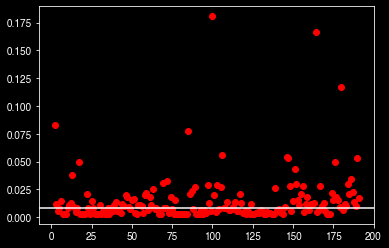

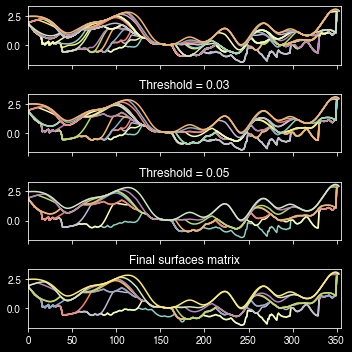

In [65]:
##### look at what removing some different threshold thicknesses will do to the data

fig = plt.figure()

bd_surfs = np.zeros([1, len(posnew)+1])
#print(fnl_surfs)

for i in range(2, bounding_surfaces.shape[0]):
    x = np.nanmean(bounding_surfaces[i, :]-bounding_surfaces[i-1, :])
    #print(x)
    
    plt.plot(i, x, 'ro')
plt.axhline(np.percentile(thickness, 70))    
fig, ax = plt.subplots(4, 1, figsize = (5, 5), tight_layout = True, sharex = True)
for i in range (0, 3):
    for j in range (0, end_t):
        ax[i].plot(posnew, erohiatalsurf[j, :], 'k',  lw = 0.1, alpha = 0.7)

mean_thickness_threshold = np.array([0.025, 0.030, 0.05])
#print(mean_thickness_threshold)
for i in range(1, bounding_surfaces.shape[0]): ##### bounding_surfaces row 0 is a row of nans, start from 2
    x = np.nanmean(bounding_surfaces[i, :]-bounding_surfaces[i-1, :]) #check to see hpw much sediment added at that time

    if x > mean_thickness_threshold[0]:
        ax[0].plot(posnew, bounding_surfaces[i, 1:])
    
    if x > mean_thickness_threshold[1]:
        ax[1].plot(posnew, bounding_surfaces[i, 1:])
        ax[1].set_title('Threshold = '+str(mean_thickness_threshold[1]))
    if x > mean_thickness_threshold.max():
        ax[2].plot(posnew, bounding_surfaces[i, 1:])
        ax[2].set_title('Threshold = '+str(mean_thickness_threshold.max()))
        bd_surfs = np.append(bd_surfs, np.reshape(bounding_surfaces[i, :], [1, len(posnew)+1]), axis = 0)
        
    #if x < 0.03:
        #print(i)
        

#print(fnl_surfs[0, :])
fnl_surfs = copy.deepcopy(bd_surfs)
fnl_surfs[0, 1:] = xy_topo[0, :]

#print(fnl_surfs[0, :])
print(bounding_surfaces.shape, bd_surfs.shape, fnl_surfs.shape)
print('number of surfaces deleted = ', (bounding_surfaces.shape[0]-1)-fnl_surfs.shape[0])

for i in range (0, len(fnl_surfs)):
    ax[3].plot(posnew, fnl_surfs[i, 1:])
ax[3].set_title('Final surfaces matrix')
ax[-1].set_xlim(0, posnew.max())

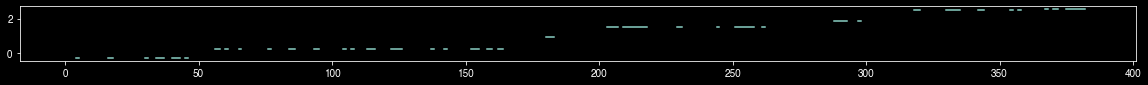

In [84]:
plt.figure(figsize = (20, 1))
# plt.plot(ages_ero[:, 100][~np.isnan(erohiatalsurf[:, 100])], marker = '+', lw = 0)
plt.plot(ages_ero[:, 100], erohiatalsurf[:,100])

##### Save Main Surfaces

In [ ]:
# np.save(f'/Volumes/SAF_Data/NAYS2DH_Files/Data/nparrays/mainsurfs/{modelrun}', fnl_surfs)

### Coring the *new* stratigraphy

I am too lazy to really change the names of things that much so Imma prefix all the copied variables with 'bs'...for 'bounding surfaces'....not bullshit. 

In [ ]:
coresthick = {} #dictionary to hold set thickness
coresbounds = {} #dictionary to hold bound surfaces
num_sets = np.empty([len(posnew), 2])
num_sets[:, 0] = posnew
threshold = 0.1
for i in range(0, len(posnew)):
    keystr = 'x'+str(i)
    
    elevatcore = np.delete(erohiatalsurf[:, i], np.where(np.isnan(erohiatalsurf[:, i])))
    bounds = np.unique(elevatcore)
    #print(i, bounds)
    
    coresbounds[keystr] = bounds #finds the bounding elevations of sets
    
    diffs = np.empty([0])
    
    for j, k in zip(bounds[:-1], bounds[1:]):
        #print(i, j, k)
        diff = k-j #more positive -- less positive = positive
        #print(diff)
        if diff > threshold:
            diffs = np.append(diffs, diff)


    coresthick[keystr] = diffs
    num_sets[i, 1] = len(diffs)
    
    #print(cores[keystr+'_thick'])
#print(cores)


In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (8, 4), tight_layout=True)
ax[0].plot(num_sets[:, 0], num_sets[:, 1], 'k')
for i in range (0, end_t):
    ax[1].plot(posnew, xy_topo[i], 'k', lw = 0.1, alpha = 0.4)
    ax[1].plot(posnew, erosurf[i], 'r', lw = 1.5)
    ax[1].plot(posnew, hiatalsurf[i], 'g', lw = 1.5)
#ax[0].set_aspect(10)    
ax[1].set_aspect(10)
ax[1].set_ylabel('Bed Elevation, m')
ax[0].set_ylabel('Number of Sets')
ax[1].set_xlabel("Cross Stream Position")
ax[0].set_xlabel("Cross Stream Position")
ax[1].legend()

ax[0].set_title('Time series of number of sets at iloc = '+str(iloc))
ax[1].set_title('Stratigraphy at '+str(iloc)+'. Ero = red, Hiatal = green')

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (14, 4), tight_layout = True)
ax[0].plot(num_sets[:, 0], num_sets[:, 1], 'k')
ax[0].set_title('Number of sets along the section')

for loc, core in zip(posnew, coresthick):
    avg = np.average(coresthick[core])
    #print(coresthick[core], avg)
    if len(coresthick[core]) >0:
        ax[1].plot(loc, np.average(coresthick[core]), 'o', markerfacecolor = 'b', markeredgecolor = 'k')
        ax[2].plot(loc, coresthick[core].max(), 'o', markerfacecolor = 'g', markeredgecolor = 'k')
        
ax[2].set_ylim(0, 2)
ax[1].set_ylim(0, 2)

ax[2].set_title('Maximum set thickness at each cor loc')
ax[1].set_title('Average set thickness at each cor loc')

fig.suptitle(str(iloc))

#plt.savefig(savefilesto+'/corestats/'+modelrun+'.png', dpi = 100)

In [ ]:
bs_coresthick = {} #dictionary to hold set thickness
bs_coresbounds = {} #dictionary to hold bound surfaces
bs_num_sets = np.empty([len(posnew), 2])
bs_num_sets[:, 0] = posnew
bs_threshold = 0.1
for i in range(0, len(posnew)):
    keystr = 'x'+str(i)
    
    elevatcore = fnl_surfs[:, i+1]
    bounds = np.unique(elevatcore)
    
    bs_coresbounds[keystr] = bounds #finds the bounding elevations of sets
    
    diffs = np.empty([0]) #temp array to store thickness of sets > a threshold thickness
    
    for j, k in zip(bounds[:-1], bounds[1:]):
        #print(i, j, k)
        diff = k-j #more positive -- less positive = positive
        if diff > bs_threshold:
            diffs = np.append(diffs, diff)
    bs_coresthick[keystr] = diffs
    bs_num_sets[i, 1] = len(diffs)
    
    #print(cores[keystr+'_thick'])
#print(cores)


In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (14, 4), tight_layout=True)
ax[0].plot(bs_num_sets[:, 0], bs_num_sets[:, 1], 'k', label = 'Main Surfaces extract')
ax[0].plot(num_sets[:, 0], num_sets[:, 1], 'k--', alpha = 0.7, label = 'True EH surfaces')
for i in range (0, end_t):
    #ax[1].plot(posnew, stratinterpcub[i], 'k', lw = 0.1, alpha = 0.4)
    #ax[1].plot(posnew, erosurf[i], 'r', lw = 2)
    #ax[1].plot(posnew, hiatalsurf[i], 'g', lw = 2)
    ax[1].plot(posnew, erohiatalsurf[i], 'r', lw = 2)
for i in range (0, len(fnl_surfs)):
    ax[1].plot(posnew, fnl_surfs[i, 1:], 'k', lw = 0.5)

for i in range(0, len(posnew)):
    ax[1].axvline(posnew[i], c = 'k', ls = 'dotted', lw = 0.3)
    ax[0].axvline(posnew[i], c = 'k', ls = 'dotted', lw = 0.3)
ax[1].set_ylabel('Bed Elevation, m')
ax[0].set_ylabel('Number of Sets')
ax[1].set_xlabel("Cross Stream Position")
ax[0].set_xlabel("Cross Stream Position")
ax[0].legend()
ax[0].set_ylim(0, 15)

ax[0].set_title('Time series of number of sets at iloc = '+str(iloc))
ax[1].set_title('Stratigraphy at '+str(iloc)+'. Ero = red, Hiatal = green')
#plt.savefig(savefilesto+'corestats/compare'+modelrun+'.png', dpi = 100)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (14, 4), tight_layout = True)
ax[0].plot(bs_num_sets[:, 0], bs_num_sets[:, 1], 'k')
ax[0].set_title('Number of sets along the section')

for loc, core in zip(posnew, bs_coresthick):
    avg = np.average(bs_coresthick[core])
    #print(coresthick[core], avg)
    if len(bs_coresthick[core]) >0:
        ax[1].plot(loc, np.average(bs_coresthick[core]), 'o', markerfacecolor = 'b', markeredgecolor = 'k')
        ax[2].plot(loc, bs_coresthick[core].max(), 'o', markerfacecolor = 'g', markeredgecolor = 'k')
        
ax[2].set_ylim(0, 2)
ax[1].set_ylim(0, 2)

ax[2].set_title('Maximum set thickness at each cor loc')
ax[1].set_title('Average set thickness at each cor loc')

fig.suptitle(str(iloc))

# plt.savefig(savefilesto+'/corestats/'+modelrun+'.png', dpi = 100)

In [ ]:
allthick_der = np.array([])
allthick_eh= np.array([])
plt.figure(figsize = (10, 6))
#print(allthicknesses_derived.shape)
for key1, key2 in zip(bs_coresthick, coresthick):

  #print(bs_coresthick[key])
  allthick_der = np.append(allthick_der, bs_coresthick[key1])
  allthick_eh = np.append(allthick_eh, coresthick[key2])
  
hist2 = plt.hist(allthick_der, **kwargs, density =True,label = 'Main Surfaces extract')
  
hist = plt.hist(allthick_eh, histtype='step', density=True, edgecolor = 'k', linewidth = 2.5, bins= 20, label='True EH thicknesses')
  
plt.legend()
plt.ylabel('Normalised Frequency')
plt.xlabel('Vertical Set Thickness, m')
plt.title('Distribution of core thicknesses of sets')